### EYE FOR BLIND: An Image Captioning Project

- This notebook is the capstone project for the EPGP program by Upgrad and IIITB. 

- The project, titled "Eye for Blind," focuses on generating descriptive captions for images.

- The implementation is roughly based on the paper: **"Show, Attend and Tell: Neural Image Caption Generation with Visual Attention"**.

### Quick Tech Review

#### 1. Architecture

* **Encoder**: Inception V3 (top removed) -> extract *mixed7* grid features -> Dense layer projects to common embedding space.
* **Decoder**: LSTM + **Bahdanau Attention** -> attends to image regions each step to predict next word.
* **Attention math**: alignment scores -> weighted context vector -> fed to LSTM with word embed.

#### 2. Training Tricks

* **Feature caching**: save pre-extracted `.npy` files to skip repeat CNN passes.
* **Mixed-precision (AMP)**: `mixed_float16` for speed & lower VRAM.
* **Custom `train_step` (@tf.function)**: fast graph execution, easy add-ons.
* **Gradient clipping**: `tf.clip_by_global_norm` to tame exploding grads.
* **Attention regularizer**: penalty if weights <> 1.0.

#### 3. Data-to-Text Bridging

* **Scheduled sampling**: linearly swap teacher forcing -> self-feeding to cut exposure bias.
* **Beam search (inference)**: keeps top-*k* partial captions + length penalty for balanced outputs.

#### 4. Training Management

* **Early stopping**: halt when val BLEU-4 stalls (patience configurable).

#### 5. Evaluation & Explainability

* **Metrics**: BLEU-1/2/3/4 + timing stats.
* **Attention heat-maps**: visualize focus per generated word.
* **EDA helpers**: caption length histos, word freq, sample previews.
* **Optional TTS**: gTTS turns captions into audio.

---

Result: a lean, cache-efficient, attention-guided captioner that’s fast to train, interpretable, and yields high-quality descriptions.


In [1]:
import os, re, time, random, collections, tqdm, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

from gtts import gTTS
from IPython.display import Audio, display

###  CONFIGURATION

In [2]:
CONFIG: Dict[str, object] = {
    # Directory containing image files
    'image_dir': '/home/flickr8k/Images',
    
    # Path to the captions file
    'caption_file': '/home/flickr8k/captions.txt',
    
    # Directory to cache extracted image features
    'feature_cache_dir': '/home/flickr8k/cache',
    
    # Number of examples to use (None means use all)
    'num_examples': None,
    
    # Maximum length of captions (in tokens)
    'max_caption_length': 50,
    
    # Minimum word frequency for vocabulary pruning
    'min_word_frequency': 5,

    # Embedding dimension for the model
    'embedding_dim': 256,
    
    # Number of units in LSTM
    'units': 512,
    
    # Dropout rate for the decoder
    'decoder_dropout': 0.5,

    # Learning rate for the optimizer
    'learning_rate': 5e-5,
    
    # Number of training epochs
    'epochs': 50,
    
    # Batch size for training
    'batch_size': 128,

    # Buffer size for shuffling the dataset
    'buffer_size': 1000,
    
    # Early stopping patience
    'patience': 8,
    
    # Path to save model checkpoints
    'checkpoint_path': './checkpoints/flickr8k_submission',
    
    # Enable mixed precision training for faster computation
    'mixed_precision': True,

    # Regularization weight for attention alignment
    'attention_reg_lambda': 0.5,
    
    # Gradient clipping value to prevent exploding gradients
    'grad_clip_value': 5.0,
    
    # Maximum probability for scheduled sampling
    'scheduled_sampling_max_prob': 0.2,
    
    # Random seed for reproducibility
    'seed': 42,
}

###  ENV SETUP

In [3]:
# Set random seeds for reproducibility
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])
tf.random.set_seed(CONFIG['seed'])

# Enable mixed precision training if configured
if CONFIG['mixed_precision']:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("[AMP] mixed_float16 policy active")
else:
    print("[AMP] disabled - using float32 throughout")

# Configure GPU memory growth to prevent memory allocation issues
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Using GPU: {physical_devices[0].name} | batch={CONFIG['batch_size']}")
else:
    print("GPU not found - fallback to CPU")

# Set AUTOTUNE for optimizing data pipeline performance
AUTOTUNE = tf.data.AUTOTUNE

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX 6000 Ada Generation, compute capability 8.9
[AMP] mixed_float16 policy active
Using GPU: /physical_device:GPU:0 | batch=128


###  DATA LOADING AND PREPROCESSING

In [4]:
class DataProcessor:
    """
    Handles loading, preprocessing, and splitting of image-caption data for image captioning.
    - Loads captions and images, checks for missing files.
    - Preprocesses captions (lowercase, remove non-alpha, add tokens).
    - Builds tokenizer and prunes vocab by min_word_frequency.
    - Splits data into train/val/test and pairs images with padded caption sequences.
    - Supports mapping to cached image features.
    - Can display random samples with captions for sanity check.
    """

    def __init__(self, config):
        # Store config and initialize all data structures
        self.config = config
        self.tokenizer: Optional[Tokenizer] = None
        self.img_to_cap_map: Dict[str, List[str]] = collections.defaultdict(list)
        self.image_paths: List[str] = []
        self.all_captions: List[str] = []
        self.train_data: List[Tuple[str, List[int]]] = []
        self.val_data: List[Tuple[str, List[int]]] = []
        self.test_data: List[Tuple[str, List[int]]] = []
        self.max_caption_length = 0
        self.vocab_size = 0
        self.num_steps_per_epoch = 0

    def load_and_preprocess_data(self):
        """
        Loads captions from CSV, checks image existence, preprocesses captions,
        builds tokenizer, prunes vocab, and computes max caption length.
        """
        print("Loading and preprocessing captions...")
        df = pd.read_csv(self.config['caption_file'], engine='python')
        df['image'] = df['image'].str.strip()
        df['caption'] = df['caption'].str.strip()

        temp_img_to_cap_map = collections.defaultdict(list)
        all_unique_img_names_from_csv = df['image'].unique()

        print(f"Checking {len(all_unique_img_names_from_csv)} unique image files from CSV...")
        found_images_count = 0

        existing_image_files = set(os.listdir(self.config['image_dir']))

        for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0], desc="Validating images & processing captions"):
            img_name = row['image']
            caption = row['caption']

            if img_name in existing_image_files:
                temp_img_to_cap_map[img_name].append(self.preprocess_text(caption))
                if img_name not in self.img_to_cap_map:
                    found_images_count += 1
                self.img_to_cap_map[img_name] = temp_img_to_cap_map[img_name]

        if found_images_count < len(all_unique_img_names_from_csv):
            print(f"Warning: {len(all_unique_img_names_from_csv) - found_images_count} images mentioned in CSV were not found in {self.config['image_dir']}. They have been discarded.")

        self.image_paths = sorted(list(self.img_to_cap_map.keys()))

        if self.config['num_examples']:
            if len(self.image_paths) > self.config['num_examples']:
                self.image_paths = random.sample(self.image_paths, self.config['num_examples'])
                self.img_to_cap_map = {img: self.img_to_cap_map[img] for img in self.image_paths}
                print(f"Using a subset of {len(self.image_paths)} images due to 'num_examples' config.")

        self.all_captions = []
        for img_name in self.image_paths:
            self.all_captions.extend(self.img_to_cap_map[img_name])

        print(f"Total valid images (with captions): {len(self.image_paths)}")
        print(f"Total valid captions: {len(self.all_captions)}")

        # Build tokenizer and prune vocab
        self.tokenizer = Tokenizer(num_words=None, oov_token="<unk>",
                                   filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                   lower=True)
        self.tokenizer.fit_on_texts(self.all_captions)

        word_counts = collections.Counter(word for caption in self.all_captions for word in caption.split())
        filtered_word_index = {
            word: index for word, index in self.tokenizer.word_index.items()
            if word_counts[word] >= self.config['min_word_frequency'] or word in ['<pad>', '<start>', '<end>', '<unk>']
        }
        self.tokenizer.word_index = filtered_word_index
        self.tokenizer.index_word = {v: k for k, v in filtered_word_index.items()}

        # Ensure special tokens are correctly in word_index and index_word with proper mapping
        special_tokens = ['<pad>', '<start>', '<end>', '<unk>']
        next_index = len(self.tokenizer.word_index) + 1
        for token in special_tokens:
            if token not in self.tokenizer.word_index:
                self.tokenizer.word_index[token] = next_index
                self.tokenizer.index_word[next_index] = token
                next_index += 1

        # This is where vocab_size is correctly determined based on the processed data.
        self.vocab_size = len(self.tokenizer.word_index) + 1 # +1 for 0-indexing
        print(f"Vocabulary size after pruning (min_word_frequency={self.config['min_word_frequency']}): {self.vocab_size}")

        all_seqs = self.tokenizer.texts_to_sequences(self.all_captions)
        self.max_caption_length = max(len(s) for s in all_seqs)
        # Update CONFIG with the dynamically determined max_caption_length
        self.config['max_caption_length'] = self.max_caption_length
        print(f"Max caption length: {self.max_caption_length}")
        
    def preprocess_text(self, caption: str) -> str:
        """
        Lowercases, removes non-alpha chars, trims, and adds <start>/<end> tokens.
        """
        caption = caption.lower()
        caption = re.sub(r"[^a-z ]", "", caption)
        caption = re.sub(r'\s+', ' ', caption).strip()
        caption = '<start> ' + caption + ' <end>'
        return caption

    def create_dataset_splits(self, train_ratio=0.8, val_ratio=0.1):
        """
        Shuffles and splits image paths into train/val/test, then pairs with captions.
        """
        random.shuffle(self.image_paths)
        num_images = len(self.image_paths)
        num_train = int(train_ratio * num_images)
        num_val = int(val_ratio * num_images)

        train_image_paths = self.image_paths[:num_train]
        val_image_paths = self.image_paths[num_train:num_train + num_val]
        test_image_paths = self.image_paths[num_train + num_val:]

        print(f"Train images: {len(train_image_paths)}, Val images: {len(val_image_paths)}, Test images: {len(test_image_paths)}")

        self.train_data = self._create_pairs(train_image_paths)
        self.val_data = self._create_pairs(val_image_paths)
        self.test_data = self._create_pairs(test_image_paths)

        print(f"Train pairs: {len(self.train_data)}, Val pairs: {len(self.val_data)}, Test pairs: {len(self.test_data)}")

        self.num_steps_per_epoch = len(self.train_data) // self.config['batch_size']

    def _create_pairs(self, image_names: List[str]) -> List[Tuple[str, List[int]]]:
        """
        For each image, pairs it with all its captions (as padded int sequences).
        """
        pairs = []
        for img_name in image_names:
            full_img_path = os.path.join(self.config['image_dir'], img_name)
            for caption in self.img_to_cap_map[img_name]:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                padded_seq = pad_sequences([seq], maxlen=self.max_caption_length, padding='post')[0]
                pairs.append((full_img_path, list(padded_seq)))
        return pairs

    def get_data_with_cached_features(self, image_name_to_cached_path_map: Dict[str, str]) -> Tuple[List, List, List]:
        """
        Replaces image paths with cached feature paths if available, for all splits.
        Only keeps pairs where cached features exist.
        """
        def _reconstruct_list(data_list):
            reconstructed = []
            for original_img_path, caption_ids in data_list:
                basename = os.path.basename(original_img_path)
                cached_path = image_name_to_cached_path_map.get(basename)
                if cached_path and os.path.exists(cached_path): # Added check if cached file actually exists
                    reconstructed.append((original_img_path, cached_path, caption_ids))
            return reconstructed

        final_train = _reconstruct_list(self.train_data)
        final_val = _reconstruct_list(self.val_data)
        final_test = _reconstruct_list(self.test_data)

        print(f"Adjusted train pairs (after feature caching check): {len(final_train)}")
        print(f"Adjusted val pairs (after feature caching check): {len(final_val)}")
        print(f"Adjusted test pairs (after feature caching check): {len(final_test)}")
        
        return final_train, final_val, final_test

    def display_samples(self, num_samples: int = 5):
        """
        Randomly picks a few images and displays them with their ground truth captions.
        Useful for sanity check of data loading and preprocessing.
        """
        print(f"\n--- Displaying {num_samples} Random Dataset Samples ---")

        # Get a list of all image paths that have associated captions
        available_image_paths = sorted(list(self.img_to_cap_map.keys()))

        if not available_image_paths:
            print("No image paths with captions available to display.")
            return

        # Randomly select a few image names
        samples_to_display = random.sample(available_image_paths, min(num_samples, len(available_image_paths)))

        for i, img_name in enumerate(samples_to_display):
            full_image_path = os.path.join(self.config['image_dir'], img_name)

            if not os.path.exists(full_image_path):
                print(f"Warning: Image file not found for {img_name} at {full_image_path}. Skipping.")
                continue

            print(f"\n--- Sample {i+1}/{num_samples} ---")
            print(f"Image Name: {img_name}")

            try:
                img = Image.open(full_image_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.title(f"Image: {img_name}")
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Error loading or displaying image {img_name}: {e}")
                continue

            gt_captions = self.img_to_cap_map.get(img_name, [])
            print("Ground Truth Captions:")
            if gt_captions:
                for j, cap in enumerate(gt_captions):
                    # Clean up <start> and <end> tokens for display
                    clean_cap = cap.replace('<start>', '').replace('<end>', '').strip()
                    print(f"  {j+1}. {clean_cap}")
            else:
                print("  No ground truth captions available for this image.")

    def plot_caption_length_histogram(self):
        caption_lengths = [len(s.split()) for s in self.all_captions]
        plt.figure(figsize=(10, 6))
        plt.hist(caption_lengths, bins=range(min(caption_lengths), max(caption_lengths) + 2), edgecolor='black')
        plt.title('Histogram of Caption Lengths')
        plt.xlabel('Caption Length (words)')
        plt.ylabel('Number of Captions')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    def plot_top_words(self, top_n: int = 20):
        words = [word for caption in self.all_captions for word in caption.split() 
                if word not in ['<start>', '<end>', '<pad>', '<unk>']]
        word_counts = collections.Counter(words)
        top_words = word_counts.most_common(top_n)
        words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

        plt.figure(figsize=(12, 7))
        sns.barplot(x='Frequency', y='Word', hue='Word', data=words_df, palette='viridis', legend=False)
        plt.title(f'Top {top_n} Most Frequent Words (excluding special tokens)')
        plt.xlabel('Frequency')
        plt.ylabel('Word')
        plt.show()

    def plot_sample_images_with_caption(self, num_images: int = 6):
        selected_images = random.sample(self.image_paths, min(num_images, len(self.image_paths)))
        
        fig, axes = plt.subplots(3, 2, figsize=(10, 15)) # 3 rows, 2 columns for 6 images
        axes = axes.flatten()

        for i, img_name in enumerate(selected_images):
            full_path = os.path.join(self.config['image_dir'], img_name)
            if not os.path.exists(full_path):
                print(f"Warning: Image {img_name} not found. Skipping.")
                continue

            try:
                img = Image.open(full_path)
                ax = axes[i]
                ax.imshow(img)
                ax.set_title(f"{img_name}\nCap: {self.img_to_cap_map[img_name][0].replace('<start>','').replace('<end>','').strip()}", fontsize=10)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
                axes[i].set_title("Image Load Error")
                axes[i].axis('off')
                continue

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()

###  IMAGE FEATURE EXTRACTION (CACHE FEATURES)

In [5]:
class ImageFeatureExtractor(Model):
    """
    Extracts image features using a pre-trained InceptionV3 model.
    - Resizes images to target size and preprocesses them for InceptionV3.
    - Extracts features from the 'mixed7' layer of the model.
    """

    def __init__(self, target_size=(299, 299)):
        """
        Initializes the feature extractor with InceptionV3.
        - Freezes the model to prevent training.
        - Extracts features from the 'mixed7' layer.
        """
        super().__init__()
        self.target_size = target_size
        self.inception_v3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
        self.inception_v3.trainable = False  # Freeze the model
        self.feature_extractor = Model(inputs=self.inception_v3.input,
                                       outputs=self.inception_v3.get_layer('mixed7').output)

    @tf.function
    def load_and_preprocess_image(self, image_path: tf.Tensor) -> tf.Tensor:
        """
        Loads and preprocesses an image for feature extraction.
        - Reads the image from the given path.
        - Decodes and resizes it to the target size.
        - Applies InceptionV3 preprocessing.
        """
        img = tf.io.read_file(image_path)  # Read image file
        img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG image
        img = tf.image.resize(img, self.target_size)  # Resize to target size
        img = tf.keras.applications.inception_v3.preprocess_input(img)  # Preprocess for InceptionV3
        return img

In [6]:
class ImageFeatureCacheManager:
    """
    Manages extraction and caching of image features using a pre-trained CNN.
    
    Extracts features from the 'mixed7' layer of InceptionV3 and saves them as .npy files
    for faster training. Features are reshaped to (289, 768) representing 17x17 spatial
    locations with 768-dimensional feature vectors.
    """
    
    def __init__(self, config, feature_extractor: ImageFeatureExtractor):
        self.config = config
        self.feature_extractor = feature_extractor
        self.cache_dir = config['feature_cache_dir']
        os.makedirs(self.cache_dir, exist_ok=True)

    def manage_feature_cache(self, image_names: List[str]) -> Dict[str, str]:
        """
        Checks for existing cached features and extracts new ones if needed.
        
        Processes images in batches to efficiently extract CNN features using GPU.
        Returns mapping from image names to their corresponding cache file paths.
        Skips images that fail feature extraction to avoid training errors.
        """
        print(f"\nManaging image feature cache in: {self.cache_dir}")
        print(f"Checking/extracting features for {len(image_names)} unique images.")

        image_name_to_cached_path = {}
        images_to_extract = []

        # Check which images need feature extraction
        for img_name in image_names:
            cache_file = os.path.join(self.cache_dir, img_name + '.npy')
            if not os.path.exists(cache_file):
                images_to_extract.append(img_name)
            image_name_to_cached_path[img_name] = cache_file

        if images_to_extract:
            print(f"Found {len(images_to_extract)} images whose features need extraction...")
            
            full_paths_for_extraction = [os.path.join(self.config['image_dir'], img_name) for img_name in images_to_extract]

            batch_size_extraction = 16 # Adjust based on your GPU memory
            for i in tqdm.tqdm(range(0, len(full_paths_for_extraction), batch_size_extraction), desc="Extracting & Caching Features"):
                batch_paths = full_paths_for_extraction[i:i+batch_size_extraction]
                
                try:
                    # Preprocess images and extract features in batch
                    img_tensors_processed = tf.stack([self.feature_extractor.load_and_preprocess_image(tf.constant(p)) for p in batch_paths])
                    
                    features_batch = self.feature_extractor.feature_extractor(img_tensors_processed)
                    
                    # Reshape to (batch_size, 17*17, 768) for attention mechanism
                    features_flat_batch = tf.reshape(features_batch, (tf.shape(features_batch)[0], -1, tf.shape(features_batch)[3]))
                    
                    # Save features for each image separately
                    for j, img_path in enumerate(batch_paths):
                        img_name = os.path.basename(img_path)
                        cache_path = os.path.join(self.cache_dir, img_name + '.npy')
                        # Save each image's features separately as (289, 768)
                        np.save(cache_path, features_flat_batch[j].numpy())
                except Exception as e:
                    print(f"\nError processing a batch during feature extraction: {e}. Skipping images in this batch.")
                    # Remove failed images from the mapping to prevent training issues
                    for img_path_in_batch in batch_paths:
                        img_name_in_batch = os.path.basename(img_path_in_batch)
                        # Remove from map if feature extraction failed, so it's not used
                        if img_name_in_batch in image_name_to_cached_path:
                            del image_name_to_cached_path[img_name_in_batch]
                    continue
        else:
            print("All image features already cached. Skipping extraction.")
            
        print("Image feature cache management complete.")
        return image_name_to_cached_path

###  MODEL ARCHITECTURE

In [7]:
class Encoder(Model):
    """
    Encoder transforms CNN features to embedding space for the decoder.
    Uses a fully connected layer to project image features to embedding dimension.
    """
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embedding_dim)

    def call(self, x):
        # Project image features to embedding dimension
        x = self.fc(x)
        return x

class BahdanauAttention(layers.Layer):
    """
    Bahdanau attention mechanism for focusing on relevant image regions.
    Computes attention weights using additive attention with tanh activation.
    Returns context vector and attention weights for visualization.
    """
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # Dense layers for computing attention scores
        self.W1 = layers.Dense(units)  # Transform features
        self.W2 = layers.Dense(units)  # Transform hidden state
        self.V = layers.Dense(1)       # Final attention score

    def call(self, features, hidden):
        # Add time dimension to hidden state for broadcasting
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # Compute attention scores using additive attention
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        
        # Convert scores to probabilities
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # Compute weighted sum of features
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, tf.squeeze(attention_weights, -1)

class Decoder(Model):
    """
    LSTM-based decoder with attention for generating captions word by word.
    Takes embedded words and attended image features to predict next word.
    Handles mixed precision training by casting states to appropriate dtype.
    """
    def __init__(self, embedding_dim, units, vocab_size, dropout=0.5):
        super(Decoder, self).__init__()
        self.units = units
        
        # Word embedding layer
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        
        # LSTM with dropout for regularization
        self.lstm = layers.LSTM(self.units,
                                 return_sequences=True,
                                 return_state=True,
                                 recurrent_initializer='glorot_uniform',
                                 dropout=dropout)

        # Dense layers for output projection
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size, dtype='float32')  # Always float32 for stable logits

        # Attention mechanism
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden_state, cell_state):
        # Get context vector from attention
        context_vector, attention_weights = self.attention(features, hidden_state)

        # Embed input word
        x = self.embedding(x)

        # Concatenate context and embedded word
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Handle mixed precision by casting to float16 if needed
        if tf.keras.mixed_precision.global_policy().compute_dtype == 'float16':
            hidden_state = tf.cast(hidden_state, tf.float16)
            cell_state = tf.cast(cell_state, tf.float16)
            x = tf.cast(x, tf.float16)

        # Pass through LSTM
        output, new_hidden_state, new_cell_state = self.lstm(x, initial_state=[hidden_state, cell_state])

        # Flatten for dense layer
        output = tf.reshape(output, (-1, output.shape[2]))

        # Project to vocabulary size
        x = self.fc1(output)
        logits = self.fc2(x)

        return logits, new_hidden_state, new_cell_state, attention_weights

###  TEXT-TO-SPEECH UTILITY

In [8]:
class TextToSpeech:
    """
    Simple wrapper around gTTS (Google Text-to-Speech) for audio playback in Jupyter.
    Handles import errors gracefully and provides audio generation for generated captions.
    """
    
    def __init__(self):
        try:
            self.gTTS = gTTS
            self.Audio = Audio
            self.display = display
            self.available = True
        except ImportError:
            print("WARNING: gTTS or IPython.display not found. Speech functionality will be disabled.")
            self.available = False

    def speak(self, text: str, filename: str = "caption_audio.mp3"):
        """
        Converts text to speech and plays audio in Jupyter notebook.
        Saves audio file locally and uses IPython.display.Audio for playback.
        """
        if not self.available:
            print("Text-to-speech functionality is not available. Please install 'gtts' and ensure running in an IPython environment.")
            return
        
        if not text.strip():
            print("Empty text, nothing to speak.")
            return
        
        try:
            # Generate speech audio file
            tts = self.gTTS(text=text, lang='en')
            tts.save(filename)
            # Play audio in notebook
            self.display(self.Audio(filename))
            print(f"Audio saved to {filename} and played.")
        except Exception as e:
            print(f"Error generating or playing audio: {e}")

###  TRAINING LOOP & UTILITIES

In [9]:
class ImageCaptioning:
    """
    Main image captioning model that combines encoder-decoder architecture with attention mechanism.
    Uses pre-extracted image features and generates captions using greedy search or beam search.
    Includes training loop with early stopping, BLEU evaluation, and visualization capabilities.
    """
    
    def __init__(self, config, processor: DataProcessor, feature_extractor: ImageFeatureExtractor):
        self.config = config
        self.processor = processor
        self.feature_extractor = feature_extractor

        self.encoder = Encoder(self.config['embedding_dim'])
        self.decoder = Decoder(self.config['embedding_dim'], self.config['units'],
                               self.processor.vocab_size, self.config['decoder_dropout'])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.config['learning_rate'])
        if self.config['mixed_precision']:
            self.optimizer = tf.keras.mixed_precision.LossScaleOptimizer(self.optimizer)

        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

        self.checkpoint_prefix = os.path.join(self.config['checkpoint_path'], "ckpt")
        self.checkpoint = tf.train.Checkpoint(encoder=self.encoder,
                                             decoder=self.decoder,
                                             optimizer=self.optimizer)
        self.checkpoint_manager = tf.train.CheckpointManager(self.checkpoint, self.config['checkpoint_path'], max_to_keep=5)

        self.tts_speaker = TextToSpeech()

        # Initialize history lists (will be loaded if checkpoint exists)
        self.train_loss_results = []
        self.val_bleu_results = []
        self.best_val_bleu = 0.0
        self.patience_counter = 0
        self.smoothing_function = SmoothingFunction().method4

        # Paths for history files
        self.train_loss_history_path = os.path.join(self.config['checkpoint_path'], "train_loss_history.json")
        self.val_bleu_history_path = os.path.join(self.config['checkpoint_path'], "val_bleu_history.json")
        self.best_val_bleu_path = os.path.join(self.config['checkpoint_path'], "best_val_bleu.txt")
        self.patience_counter_path = os.path.join(self.config['checkpoint_path'], "patience_counter.txt")


        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f"Restored from {self.checkpoint_manager.latest_checkpoint}")
            self._load_history() # Load history after restoring checkpoint
        else:
            print("Initializing from scratch.")
        
        # Ensure checkpoint path exists for saving history files
        os.makedirs(self.config['checkpoint_path'], exist_ok=True)

    def _save_history(self):
        """Saves training history and best metric/patience to files."""
        try:
            with open(self.train_loss_history_path, 'w') as f:
                # Convert numpy floats to native floats for JSON serialization
                json.dump([float(x) for x in self.train_loss_results], f)
            with open(self.val_bleu_history_path, 'w') as f:
                json.dump([float(x) for x in self.val_bleu_results], f)
            with open(self.best_val_bleu_path, 'w') as f:
                f.write(str(self.best_val_bleu))
            with open(self.patience_counter_path, 'w') as f:
                f.write(str(self.patience_counter))
            print("Training history and states saved.")
        except Exception as e:
            print(f"Warning: Could not save training history and states: {e}")

    def _load_history(self):
        """Loads training history and best metric/patience from files."""
        try:
            if os.path.exists(self.train_loss_history_path):
                with open(self.train_loss_history_path, 'r') as f:
                    self.train_loss_results = json.load(f)
            if os.path.exists(self.val_bleu_history_path):
                with open(self.val_bleu_history_path, 'r') as f:
                    self.val_bleu_results = json.load(f)
            if os.path.exists(self.best_val_bleu_path):
                with open(self.best_val_bleu_path, 'r') as f:
                    self.best_val_bleu = float(f.read())
            if os.path.exists(self.patience_counter_path):
                with open(self.patience_counter_path, 'r') as f:
                    self.patience_counter = int(f.read())
            print("Training history and states loaded.")
        except Exception as e:
            print(f"Warning: Could not load training history and states: {e}")

    def loss_function(self, real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_mean(loss_)

    @tf.function
    def train_step(self, img_tensor, target):
        batch_size = tf.shape(target)[0]
        loss = 0.0

        current_policy = tf.keras.mixed_precision.global_policy()
        if current_policy.name == 'mixed_float16':
            initial_state_dtype = tf.float16
        else:
            initial_state_dtype = tf.float32

        hidden = tf.zeros((batch_size, self.config['units']), dtype=initial_state_dtype)
        cell = tf.zeros((batch_size, self.config['units']), dtype=initial_state_dtype)

        dec_input = tf.fill([batch_size, 1], self.processor.tokenizer.word_index['<start>'])

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)

            attention_sum_square_error = tf.constant(0.0, dtype=tf.float32)

            for i in tf.range(1, target.shape[1]):
                predictions, hidden, cell, attention_weights = self.decoder(dec_input, features, hidden, cell)

                loss += self.loss_function(target[:, i], predictions)

                if self.config.get('scheduled_sampling_max_prob', 0.0) > 0:
                    random_probs = tf.random.uniform([batch_size], 0, 1, dtype=tf.float32)
                    
                    threshold = tf.fill([batch_size], self.current_scheduled_sampling_prob)
                    
                    use_predicted_mask = random_probs < threshold
                    
                    predicted_ids = tf.argmax(predictions, axis=1, output_type=tf.int32)
                    
                    true_ids = target[:, i]
                    
                    dec_input = tf.where(use_predicted_mask, predicted_ids, true_ids)
                    
                    dec_input = tf.expand_dims(dec_input, 1)
                else:
                    dec_input = tf.expand_dims(target[:, i], 1)

                attention_sum_square_error += tf.reduce_mean(
                    tf.square(tf.cast(tf.reduce_sum(attention_weights, axis=1), tf.float32) - 1.0)
                )

            total_loss = (loss / tf.cast(target.shape[1] - 1, tf.float32))
            total_loss += self.config['attention_reg_lambda'] * attention_sum_square_error / tf.cast(target.shape[1] - 1, tf.float32)

            if self.config['mixed_precision']:
                scaled_loss = self.optimizer.get_scaled_loss(total_loss)
            else:
                scaled_loss = total_loss

        trainable_variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(scaled_loss, trainable_variables)

        if self.config['mixed_precision']:
            gradients = self.optimizer.get_unscaled_gradients(gradients)

        gradients, _ = tf.clip_by_global_norm(gradients, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        return total_loss

    def evaluate_bleu_score(self, dataset_pairs: List[Tuple[str, List[int]]], num_samples=None):
        references = []
        hypotheses = []

        if num_samples is None:
            samples_to_evaluate = dataset_pairs
        else:
            samples_to_evaluate = random.sample(dataset_pairs, min(num_samples, len(dataset_pairs)))

        print(f"\nEvaluating BLEU on {len(samples_to_evaluate)} samples...")
        for img_path, _ in tqdm.tqdm(samples_to_evaluate):
            generated_caption_tokens = self.greedy_inference(img_path)
            
            if not generated_caption_tokens:
                generated_caption_tokens, _ = self.beam_search_inference(img_path, beam_size=3)

            if not generated_caption_tokens:
                continue

            hypotheses.append(generated_caption_tokens)

            img_name = os.path.basename(img_path)
            raw_captions = self.processor.img_to_cap_map.get(img_name, [])
            
            img_references = []
            for raw_cap in raw_captions:
                cleaned_cap = raw_cap.replace('<start>', '').replace('<end>', '').strip()
                if cleaned_cap:
                    img_references.append(cleaned_cap.split())
            
            if img_references:
                references.append(img_references)
            else:
                hypotheses.pop()

        if not references:
            print("No valid reference captions found for BLEU evaluation after filtering.")
            return {"bleu-1": 0.0, "bleu-2": 0.0, "bleu-3": 0.0, "bleu-4": 0.0}

        bleu_scores = {}
        for n in range(1, 5):
            weights = (1.0 / n,) * n + (0.0,) * (4 - n)
            bleu_scores[f"bleu-{n}"] = corpus_bleu(references, hypotheses, weights=weights,
                                                   smoothing_function=self.smoothing_function)
            print(f"BLEU-{n}: {bleu_scores[f'bleu-{n}']:.4f}")
            
        return bleu_scores

    def greedy_inference(self, image_path: str):
        filename = os.path.basename(image_path)
        feature_cache_path = os.path.join(self.config['feature_cache_dir'], filename + '.npy')
        
        if not os.path.exists(feature_cache_path):
            print(f"Error: Feature cache not found for {image_path}")
            return []

        img_features = np.load(feature_cache_path)
        img_features_tensor = tf.convert_to_tensor(img_features, dtype=tf.float32)
        
        img_features_tensor = tf.expand_dims(img_features_tensor, 0)

        features = self.encoder(img_features_tensor)

        hidden = tf.zeros((1, self.config['units']), dtype=tf.float32)
        cell = tf.zeros((1, self.config['units']), dtype=tf.float32)

        dec_input = tf.expand_dims([self.processor.tokenizer.word_index['<start>']], 0)

        result = []
        for i in range(self.config['max_caption_length']):
            predictions, hidden, cell, _ = self.decoder(dec_input, features, hidden, cell)
            predicted_id = tf.argmax(predictions[0]).numpy()
            predicted_word = self.processor.tokenizer.index_word.get(predicted_id, '<unk>')

            if predicted_word == '<end>':
                break
            if predicted_word not in ('<unk>', '<start>', '<pad>'):
                result.append(predicted_word)

            dec_input = tf.expand_dims([predicted_id], 0)

        return result

    def beam_search_inference(self, image_path: str, beam_size: int = 3, length_penalty_weight: float = 0.7):
        filename = os.path.basename(image_path)
        feature_cache_path = os.path.join(self.config['feature_cache_dir'], filename + '.npy')
        if not os.path.exists(feature_cache_path):
            print(f"Error: Feature cache not found for {image_path}")
            return [], []

        img_features = np.load(feature_cache_path)
        img_features_tensor = tf.convert_to_tensor(img_features, dtype=tf.float32)
        
        img_features_tensor = tf.expand_dims(img_features_tensor, 0)

        features = self.encoder(img_features_tensor)

        start_token = self.processor.tokenizer.word_index['<start>']
        end_token = self.processor.tokenizer.word_index['<end>']

        beams = [(
            [start_token],
            0.0,
            tf.zeros((1, self.config['units']), dtype=tf.float32),
            tf.zeros((1, self.config['units']), dtype=tf.float32),
            []
        )]

        completed_beams = []

        for _ in range(self.config['max_caption_length']):
            temp_active_beams = []
            for seq, score, hidden, cell, alphas in beams:
                last_token = seq[-1]

                if last_token == end_token:
                    completed_beams.append((seq, score, alphas))
                    continue

                dec_input = tf.expand_dims([last_token], 0)
                
                predictions, new_hidden, new_cell, attention_weights = self.decoder(dec_input, features, hidden, cell)

                predictions = tf.cast(predictions[0], tf.float32)
                log_probs = tf.nn.log_softmax(predictions).numpy()

                top_k_indices = np.argsort(log_probs)[::-1][:beam_size]

                for idx in top_k_indices:
                    token_id = int(idx)
                    token_log_prob = float(log_probs[idx])
                    
                    temp_active_beams.append((
                        seq + [token_id],
                        score + token_log_prob,
                        new_hidden,
                        new_cell,
                        alphas + [attention_weights[0].numpy()]
                    ))
            
            temp_active_beams.sort(key=lambda x: x[1] / ((len(x[0]) ** length_penalty_weight) if len(x[0]) > 0 else 1.0), reverse=True)
            beams = temp_active_beams[:beam_size]

            if all(b[0][-1] == end_token for b in beams):
                completed_beams.extend([(b[0], b[1], b[4]) for b in beams])
                break
        
        completed_beams.extend([(seq, score, alphas) for seq, score, hidden, cell, alphas in beams if seq[-1] != end_token])

        if not completed_beams:
            return [], []

        best_seq, best_score, best_alphas = max(completed_beams, key=lambda x: x[1] / ((len(x[0]) ** length_penalty_weight) if len(x[0]) > 0 else 1.0))

        caption_words = [self.processor.tokenizer.index_word.get(i, '<unk>') for i in best_seq]
        
        filtered_caption_words = [
            word for word in caption_words
            if word not in ['<start>', '<end>', '<pad>', '<unk>']
        ]

        return filtered_caption_words, best_alphas

    def train(self, train_cached_paths: List[Tuple[str, str, List[int]]],
              val_dataset_pairs: List[Tuple[str, List[int]]]):
        
        def _data_generator():
            for orig_img_path, cache_path, caption_ids in train_cached_paths:
                features = np.load(cache_path)
                features = tf.cast(features, tf.float32)
                yield features, np.array(caption_ids, dtype=np.int32)

        train_dataset = tf.data.Dataset.from_generator(
            _data_generator,
            output_signature=(
                tf.TensorSpec(shape=(289, 768), dtype=tf.float32),
                tf.TensorSpec(shape=(self.config['max_caption_length'],), dtype=tf.int32)
            )
        )
        train_dataset = train_dataset.shuffle(self.config['buffer_size']).batch(self.config['batch_size'])
        train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

        self.processor.num_steps_per_epoch = len(train_cached_paths) // self.config['batch_size']
        if self.processor.num_steps_per_epoch == 0:
            print("Warning: num_steps_per_epoch is 0. Batch size might be too large or dataset too small. Setting to 1.")
            self.processor.num_steps_per_epoch = 1

        initial_epoch = tf.cast(self.optimizer.iterations, tf.float32) // self.processor.num_steps_per_epoch
        initial_epoch = tf.cast(initial_epoch, tf.int32).numpy()

        print(f"Resuming training from epoch {initial_epoch + 1}.")
        print(f"Targeting a total of {self.config['epochs']} epochs.")

        for epoch in range(initial_epoch, self.config['epochs']):
            start = time.time()
            total_loss = 0

            self.current_scheduled_sampling_prob = (
                self.config['scheduled_sampling_max_prob'] * (epoch / max(1, self.config['epochs'] - 1))
            )
            print(f"\nEpoch {epoch+1}/{self.config['epochs']} (Scheduled Sampling Prob: {self.current_scheduled_sampling_prob:.3f})")

            for (batch, (img_tensor, target)) in enumerate(train_dataset):
                batch_loss = self.train_step(img_tensor, target)
                total_loss += batch_loss

                if (self.optimizer.iterations.numpy() % 100 == 0) and (self.optimizer.iterations.numpy() > 0):
                    print(f'Global Step {self.optimizer.iterations.numpy()} Batch {batch} Loss {batch_loss.numpy():.4f}')
            
            avg_train_loss = total_loss / self.processor.num_steps_per_epoch
            
            # Ensure train_loss_results has enough entries for the current epoch
            if len(self.train_loss_results) <= epoch:
                self.train_loss_results.append(avg_train_loss.numpy())
            else:
                self.train_loss_results[epoch] = avg_train_loss.numpy()

            print(f'Epoch {epoch+1} Loss {avg_train_loss:.4f}')

            val_bleu_scores = self.evaluate_bleu_score(val_dataset_pairs, num_samples=min(1000, len(val_dataset_pairs)))
            current_val_bleu4 = val_bleu_scores.get('bleu-4', 0.0)
            
            # Ensure val_bleu_results has enough entries for the current epoch
            if len(self.val_bleu_results) <= epoch:
                self.val_bleu_results.append(current_val_bleu4)
            else:
                self.val_bleu_results[epoch] = current_val_bleu4

            if current_val_bleu4 > self.best_val_bleu:
                self.best_val_bleu = current_val_bleu4
                self.checkpoint_manager.save()
                self._save_history() # Save history whenever a checkpoint is saved
                print(f"Saving checkpoint at epoch {epoch+1} with BLEU-4: {current_val_bleu4:.4f}")
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                print(f"BLEU-4 not improved. Patience counter: {self.patience_counter}/{self.config['patience']}")
                if self.patience_counter >= self.config['patience']:
                    print(f"Early stopping triggered at epoch {epoch+1}.")
                    break

            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs')

    def plot_history(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_results, label='Train Loss')
        plt.title('Training Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.val_bleu_results, label='Validation BLEU-4')
        plt.title('Validation BLEU-4 Score per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4 Score')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_attention(self, image_path: str, caption: List[str], alphas: List[np.ndarray]):
        img = Image.open(image_path)
        img = np.array(img.resize((299, 299)))

        num_words = len(caption)
        cols = min(5, num_words)
        rows = (num_words + cols - 1) // cols

        fig_width = cols * 4
        fig_height = rows * 4 + 2

        fig = plt.figure(figsize=(fig_width, fig_height))
        fig.subplots_adjust(wspace=0.1, hspace=0.3)

        for t in range(num_words):
            if t >= (rows * cols): 
                break
            
            ax = fig.add_subplot(rows, cols, t + 1)
            ax.imshow(img)
            ax.axis('off')

            alpha = np.array(alphas[t])
            attention_grid_size = int(np.sqrt(alpha.shape[0]))
            alpha_reshaped = alpha.reshape(attention_grid_size, attention_grid_size)

            alpha_resized = Image.fromarray(np.uint8(255 * alpha_reshaped)).resize(
                (299, 299), resample=Image.Resampling.BICUBIC
            )
            alpha_resized = np.array(alpha_resized) / 255.0

            ax.imshow(alpha_resized, cmap='jet', alpha=0.4, extent=(0, 299, 299, 0))
            ax.set_title(f"{t+1}: '{caption[t]}'", fontsize=12, color='blue', va='bottom')

        plt.suptitle(f"Attention Map for: {os.path.basename(image_path)}", fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        self.tts_speaker.speak(caption, filename)

    def demo(self, image_file_name: str):
        full_image_path = os.path.join(self.config['image_dir'], image_file_name)
        
        if not os.path.exists(full_image_path):
            print(f"Error: Image not found at {full_image_path}")
            return

        img = Image.open(full_image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Image: {image_file_name}")
        plt.axis('off')
        plt.show()

        gt_captions = self.processor.img_to_cap_map.get(image_file_name, [])
        print("\nGround Truth Captions:")
        if gt_captions:
            for i, cap in enumerate(gt_captions):
                clean_cap = cap.replace('<start>', '').replace('<end>', '').strip()
                print(f"  {i+1}. {clean_cap}")
        else:
            print("  No ground truth captions available.")
        
        generated_caption_words, attention_weights = self.beam_search_inference(full_image_path, beam_size=3)
        generated_caption = " ".join(generated_caption_words)
        print(f"\nGenerated Caption (Beam Search): {generated_caption}")

        print("\nPlaying generated caption:")
        self.speak_caption(generated_caption, filename=f"caption_audio_{os.path.basename(image_file_name).split('.')[0]}.mp3")

        if generated_caption_words and attention_weights:
            self.plot_attention(full_image_path, generated_caption_words, attention_weights)
        else:
            print("Could not generate caption or attention for plotting.")

    def run_prediction_samples(self, dataset_pairs: List[Tuple[str, List[int]]], num_samples: int = 10):
        """
        Loops over N random cases from the dataset, prints ground truth captions and predictions,
        and provides prediction time statistics.

        Args:
            dataset_pairs: A list of (image_path, caption_ids) tuples for the dataset split (e.g., test_data).
            num_samples: The number of random samples to predict and display.
        """
        print(f"\n--- Running Predictions for {num_samples} Random Samples ---")

        if not dataset_pairs:
            print("No data available for prediction samples.")
            return

        samples_to_predict = random.sample(dataset_pairs, min(num_samples, len(dataset_pairs)))

        prediction_times = []

        for i, (img_path, _) in enumerate(samples_to_predict):
            img_name = os.path.basename(img_path)
            
            print(f"\n--- Prediction Sample {i+1}/{num_samples} (Image: {img_name}) ---")
            
            # Ground Truth Captions
            gt_captions = self.processor.img_to_cap_map.get(img_name, [])
            print("Ground Truth Captions:")
            if gt_captions:
                for j, cap in enumerate(gt_captions):
                    clean_cap = cap.replace('<start>', '').replace('<end>', '').strip()
                    print(f"  {j+1}. {clean_cap}")
            else:
                print("  No ground truth captions available for this image.")

            # Generated Caption and Prediction Time
            start_time = time.perf_counter()
            generated_caption_words, _ = self.beam_search_inference(img_path, beam_size=3)
            end_time = time.perf_counter()
            
            prediction_time = (end_time - start_time) * 1000 # in milliseconds
            prediction_times.append(prediction_time)

            generated_caption = " ".join(generated_caption_words)
            print(f"Generated Caption (Beam Search): {generated_caption}")
            print(f"Prediction Time: {prediction_time:.2f} ms")

        if prediction_times:
            avg_time = np.mean(prediction_times)
            std_time = np.std(prediction_times)
            print(f"\n--- Prediction Statistics ({len(prediction_times)} samples) ---")
            print(f"Average Prediction Time: {avg_time:.2f} ms")
            print(f"Standard Deviation of Prediction Time: {std_time:.2f} ms")
        else:
            print("\nNo predictions were made.")

    def summary(self):
            """
            Prints the summary of the Encoder and Decoder models.
            Builds the models using dummy input tensors if they haven't been built yet.
            """
            print("\n--- Model Summaries ---")

            # Encoder Model Summary
            print("\nEncoder Model Summary:")
            # Encoder input shape is (batch_size, 289, 768)
            dummy_encoder_input = tf.zeros((1, 289, 768), dtype=tf.float32)
            # Call the encoder once to build it
            _ = self.encoder(dummy_encoder_input)
            self.encoder.summary()

            # Decoder Model Summary
            print("\nDecoder Model Summary:")
            # Decoder's call method signature: call(self, x, features, hidden_state, cell_state)
            # We need to provide dummy tensors for all these arguments to build it.
            # x: (batch_size, 1) for token ID
            # features: (batch_size, 289, embedding_dim)
            # hidden_state: (batch_size, units)
            # cell_state: (batch_size, units)

            batch_size_dummy = 1
            embedding_dim_dummy = self.config['embedding_dim']
            units_dummy = self.config['units']

            dummy_dec_input = tf.zeros((batch_size_dummy, 1), dtype=tf.int32) # Word ID
            dummy_features = tf.zeros((batch_size_dummy, 289, embedding_dim_dummy), dtype=tf.float32)
            dummy_hidden_state = tf.zeros((batch_size_dummy, units_dummy), dtype=tf.float32)
            dummy_cell_state = tf.zeros((batch_size_dummy, units_dummy), dtype=tf.float32)
            
            # Call the decoder once with dummy inputs to build it
            _ = self.decoder(dummy_dec_input, dummy_features, dummy_hidden_state, dummy_cell_state)
            self.decoder.summary()

###  DATA AND FEATURES

#### Load data

In [10]:
processor = DataProcessor(CONFIG)

In [11]:
processor.load_and_preprocess_data()

Loading and preprocessing captions...
Checking 8091 unique image files from CSV...


Validating images & processing captions: 100%|██████████| 40455/40455 [00:00<00:00, 51283.26it/s]


Total valid images (with captions): 8091
Total valid captions: 40455
Vocabulary size after pruning (min_word_frequency=5): 2989
Max caption length: 37


#### Quick EDA

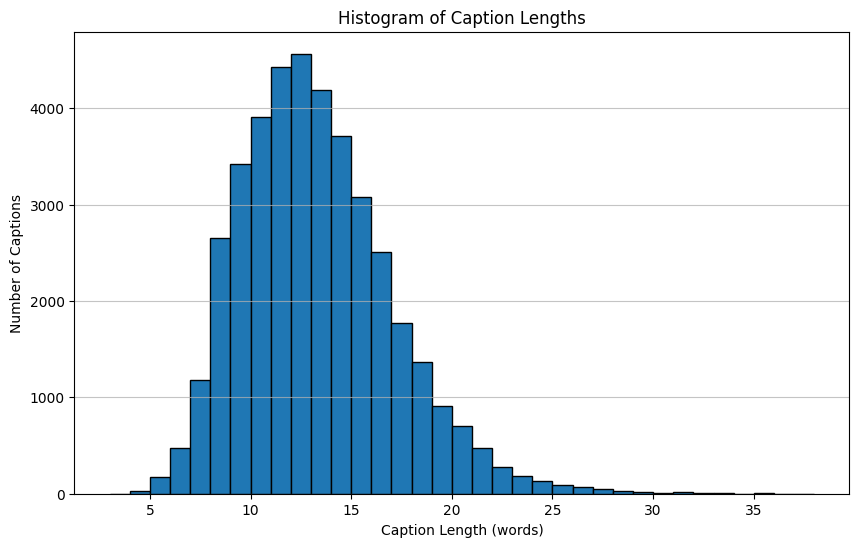

In [12]:
processor.plot_caption_length_histogram()

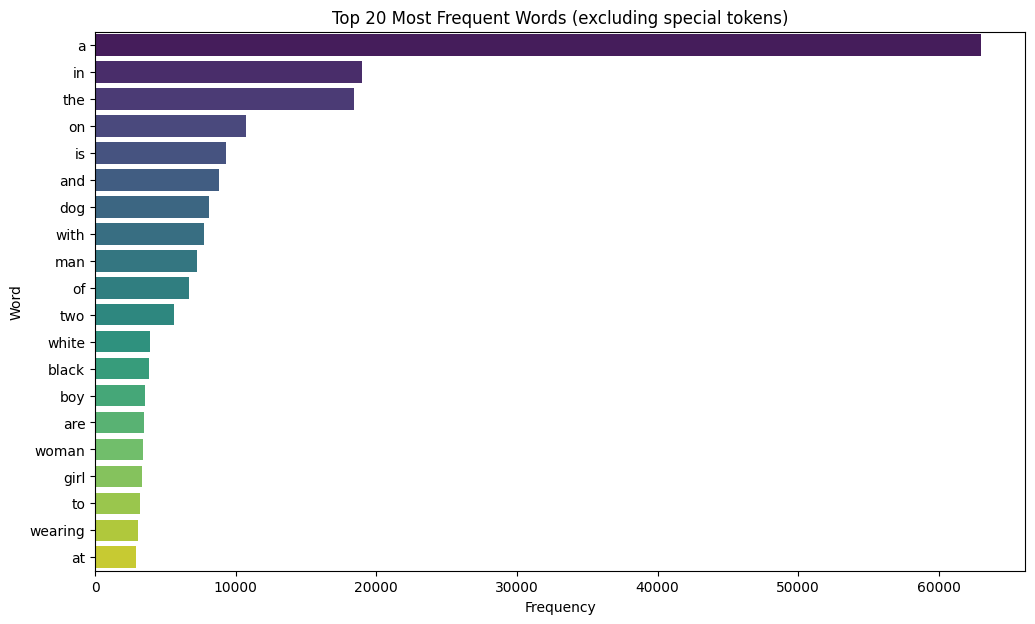

In [13]:
processor.plot_top_words(top_n=20)

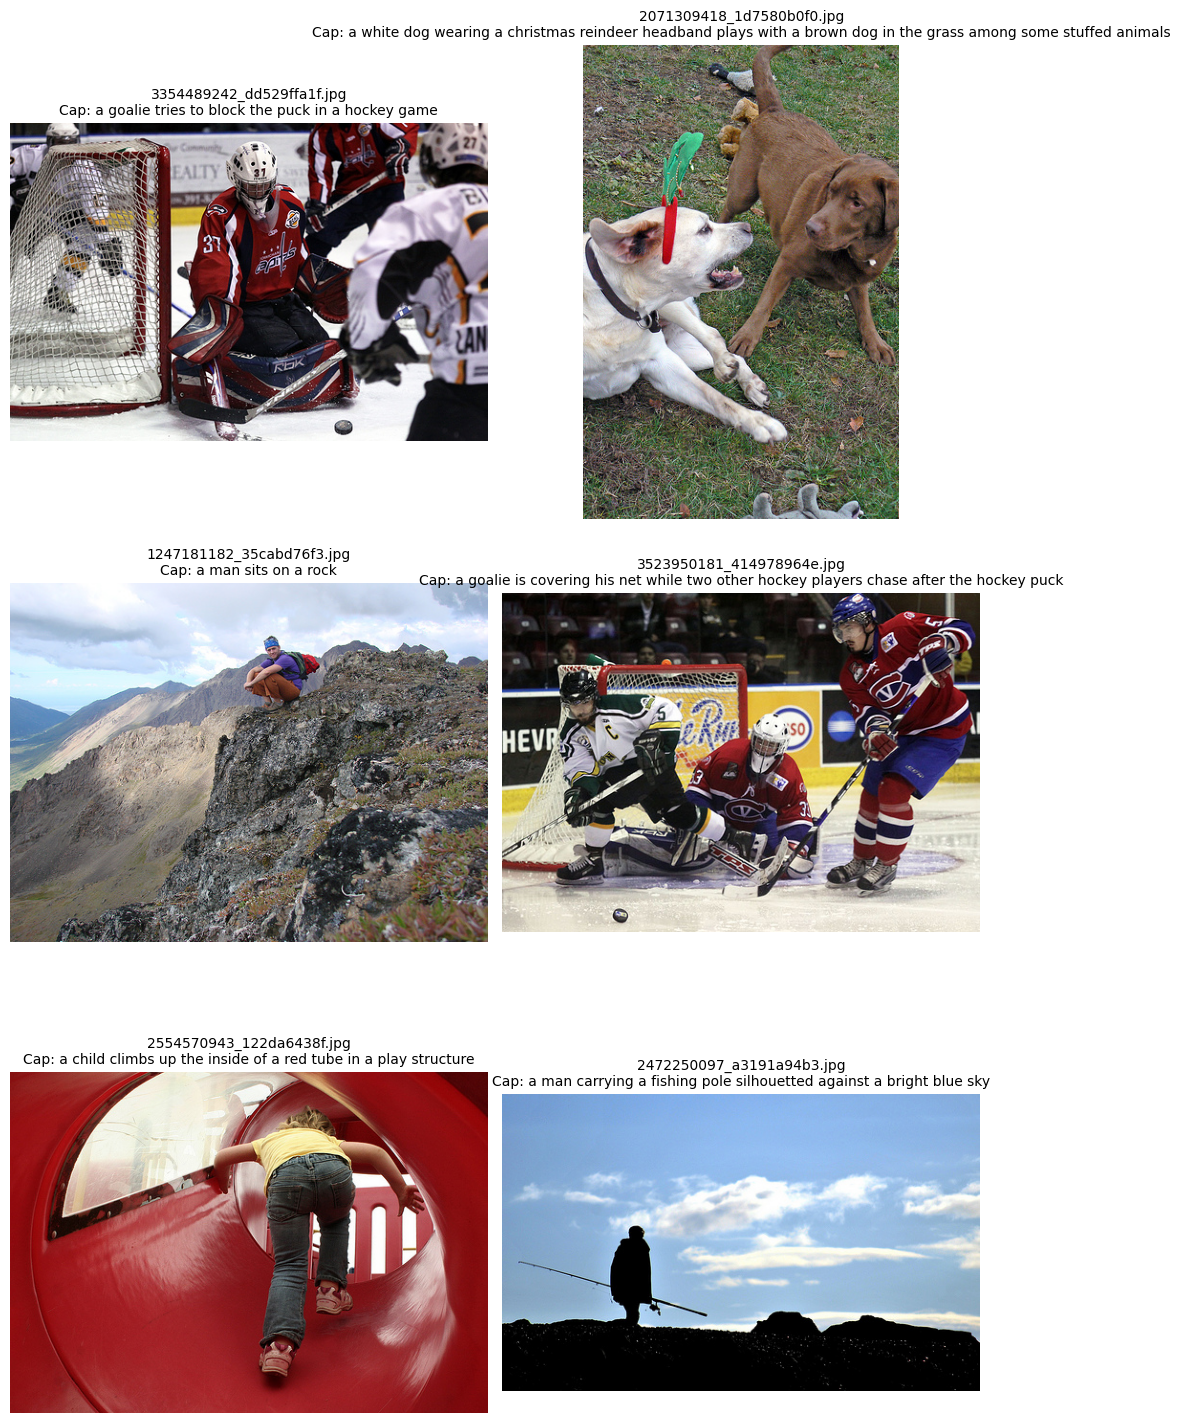

In [14]:
processor.plot_sample_images_with_caption(num_images=6)


#### Review of the built dataset


--- Displaying 2 Random Dataset Samples ---

--- Sample 1/2 ---
Image Name: 2419591925_1038c6c570.jpg


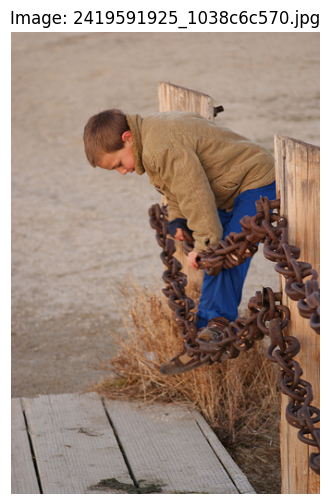

Ground Truth Captions:
  1. a boy in a brown jacket is standing on chains between two wooden posts
  2. a child standing on a heavy chain fence at a dock
  3. a little boy climbing over a chain fence
  4. a little boy standing and playing on a chained fence
  5. boy climbing on a chain fence

--- Sample 2/2 ---
Image Name: 2180480870_dcaf5ac0df.jpg


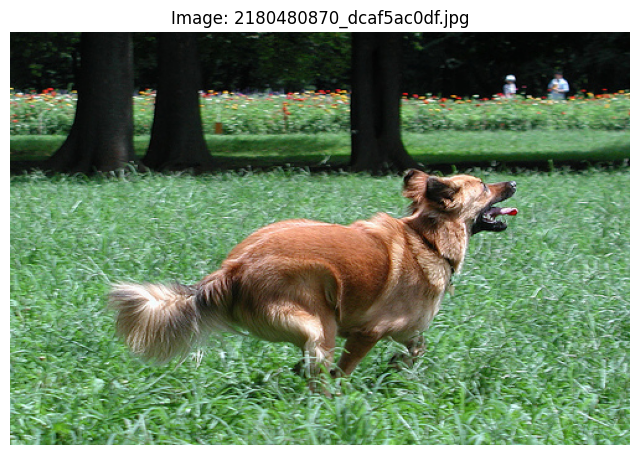

Ground Truth Captions:
  1. a brown dog is about to jump
  2. a dog runs through the grass
  3. a little brown dog running through a field of grass
  4. tan dog running through long grass in a parklike setting
  5. the large brownish dog is running through a grassy area


In [15]:
processor.display_samples(2)

#### Train, Val, Test split 

In [16]:
processor.create_dataset_splits(train_ratio=0.85, val_ratio=0.1)

Train images: 6877, Val images: 809, Test images: 405
Train pairs: 34385, Val pairs: 4045, Test pairs: 2025


#### Feature extractor

In [17]:
feature_extractor_model = ImageFeatureExtractor()

In [18]:
cache_manager = ImageFeatureCacheManager(CONFIG, feature_extractor_model)
image_name_to_cached_path_map = cache_manager.manage_feature_cache(processor.image_paths)
final_train_data, final_val_data, final_test_data = processor.get_data_with_cached_features(image_name_to_cached_path_map)


Managing image feature cache in: /home/flickr8k/cache
Checking/extracting features for 8091 unique images.
All image features already cached. Skipping extraction.
Image feature cache management complete.
Adjusted train pairs (after feature caching check): 34385
Adjusted val pairs (after feature caching check): 4045
Adjusted test pairs (after feature caching check): 2025


### CAPTIONING MODEL

In [19]:
trainer = ImageCaptioning(CONFIG, processor, feature_extractor_model)

Initializing from scratch.


In [20]:
trainer.summary()


--- Model Summaries ---

Encoder Model Summary:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  196864    
                                                                 
Total params: 196,864
Trainable params: 196,864
Non-trainable params: 0
_________________________________________________________________

Decoder Model Summary:
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  765184    
                                                                 
 lstm (LSTM)                 multiple                  2099200   
                                                                 
 dense_1 (Dense)             multiple                  262656    
                             

### MODEL TRAINING

In [21]:
trainer.train(final_train_data, processor.val_data)

Resuming training from epoch 1.
Targeting a total of 50 epochs.

Epoch 1/50 (Scheduled Sampling Prob: 0.000)
Global Step 100 Batch 99 Loss 1.7134
Global Step 200 Batch 199 Loss 1.5052
Epoch 1 Loss 1.8168

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [00:59<00:00, 16.89it/s]


BLEU-1: 0.3954
BLEU-2: 0.1520
BLEU-3: 0.0379
BLEU-4: 0.0135
Training history and states saved.
Saving checkpoint at epoch 1 with BLEU-4: 0.0135
Time taken for 1 epoch: 109.49 secs

Epoch 2/50 (Scheduled Sampling Prob: 0.004)
Global Step 300 Batch 30 Loss 1.6741
Global Step 400 Batch 130 Loss 1.6208
Global Step 500 Batch 230 Loss 1.5179
Epoch 2 Loss 1.5673

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [00:55<00:00, 17.87it/s]


BLEU-1: 0.4844
BLEU-2: 0.2557
BLEU-3: 0.1185
BLEU-4: 0.0647
Training history and states saved.
Saving checkpoint at epoch 2 with BLEU-4: 0.0647
Time taken for 1 epoch: 101.87 secs

Epoch 3/50 (Scheduled Sampling Prob: 0.008)
Global Step 600 Batch 61 Loss 1.3575
Global Step 700 Batch 161 Loss 1.4516
Global Step 800 Batch 261 Loss 1.4765
Epoch 3 Loss 1.4649

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:01<00:00, 16.31it/s]


BLEU-1: 0.5074
BLEU-2: 0.2841
BLEU-3: 0.1343
BLEU-4: 0.0746
Training history and states saved.
Saving checkpoint at epoch 3 with BLEU-4: 0.0746
Time taken for 1 epoch: 107.68 secs

Epoch 4/50 (Scheduled Sampling Prob: 0.012)
Global Step 900 Batch 92 Loss 1.3858
Global Step 1000 Batch 192 Loss 1.3334
Epoch 4 Loss 1.3695

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:17<00:00, 12.90it/s]


BLEU-1: 0.4920
BLEU-2: 0.2888
BLEU-3: 0.1500
BLEU-4: 0.0828
Training history and states saved.
Saving checkpoint at epoch 4 with BLEU-4: 0.0828
Time taken for 1 epoch: 123.29 secs

Epoch 5/50 (Scheduled Sampling Prob: 0.016)
Global Step 1100 Batch 23 Loss 1.3003
Global Step 1200 Batch 123 Loss 1.4368
Global Step 1300 Batch 223 Loss 1.2477
Epoch 5 Loss 1.3009

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [02:30<00:00,  6.64it/s]


BLEU-1: 0.2563
BLEU-2: 0.1491
BLEU-3: 0.0797
BLEU-4: 0.0448
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 196.49 secs

Epoch 6/50 (Scheduled Sampling Prob: 0.020)
Global Step 1400 Batch 54 Loss 1.2439
Global Step 1500 Batch 154 Loss 1.2970
Global Step 1600 Batch 254 Loss 1.2589
Epoch 6 Loss 1.2543

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]


BLEU-1: 0.1938
BLEU-2: 0.1125
BLEU-3: 0.0609
BLEU-4: 0.0338
BLEU-4 not improved. Patience counter: 2/8
Time taken for 1 epoch: 221.71 secs

Epoch 7/50 (Scheduled Sampling Prob: 0.024)
Global Step 1700 Batch 85 Loss 1.2111
Global Step 1800 Batch 185 Loss 1.1781
Epoch 7 Loss 1.2185

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [02:35<00:00,  6.44it/s]


BLEU-1: 0.2437
BLEU-2: 0.1412
BLEU-3: 0.0738
BLEU-4: 0.0406
BLEU-4 not improved. Patience counter: 3/8
Time taken for 1 epoch: 200.13 secs

Epoch 8/50 (Scheduled Sampling Prob: 0.029)
Global Step 1900 Batch 16 Loss 1.2311
Global Step 2000 Batch 116 Loss 1.2218
Global Step 2100 Batch 216 Loss 1.1886
Epoch 8 Loss 1.1891

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]


BLEU-1: 0.3722
BLEU-2: 0.2219
BLEU-3: 0.1216
BLEU-4: 0.0691
BLEU-4 not improved. Patience counter: 4/8
Time taken for 1 epoch: 152.40 secs

Epoch 9/50 (Scheduled Sampling Prob: 0.033)
Global Step 2200 Batch 47 Loss 1.1547
Global Step 2300 Batch 147 Loss 1.1542
Global Step 2400 Batch 247 Loss 1.0959
Epoch 9 Loss 1.1642

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:33<00:00, 10.72it/s]


BLEU-1: 0.4586
BLEU-2: 0.2785
BLEU-3: 0.1488
BLEU-4: 0.0836
Training history and states saved.
Saving checkpoint at epoch 9 with BLEU-4: 0.0836
Time taken for 1 epoch: 138.94 secs

Epoch 10/50 (Scheduled Sampling Prob: 0.037)
Global Step 2500 Batch 78 Loss 1.1705
Global Step 2600 Batch 178 Loss 1.1262
Epoch 10 Loss 1.1421

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:24<00:00, 11.86it/s]


BLEU-1: 0.5006
BLEU-2: 0.3087
BLEU-3: 0.1676
BLEU-4: 0.0939
Training history and states saved.
Saving checkpoint at epoch 10 with BLEU-4: 0.0939
Time taken for 1 epoch: 129.26 secs

Epoch 11/50 (Scheduled Sampling Prob: 0.041)
Global Step 2700 Batch 9 Loss 1.1667
Global Step 2800 Batch 109 Loss 1.0750
Global Step 2900 Batch 209 Loss 1.1215
Epoch 11 Loss 1.1223

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:26<00:00, 11.54it/s]


BLEU-1: 0.5109
BLEU-2: 0.3213
BLEU-3: 0.1819
BLEU-4: 0.1066
Training history and states saved.
Saving checkpoint at epoch 11 with BLEU-4: 0.1066
Time taken for 1 epoch: 132.78 secs

Epoch 12/50 (Scheduled Sampling Prob: 0.045)
Global Step 3000 Batch 40 Loss 1.1558
Global Step 3100 Batch 140 Loss 1.0931
Global Step 3200 Batch 240 Loss 1.0749
Epoch 12 Loss 1.1038

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:31<00:00, 10.96it/s]


BLEU-1: 0.4838
BLEU-2: 0.3057
BLEU-3: 0.1774
BLEU-4: 0.1086
Training history and states saved.
Saving checkpoint at epoch 12 with BLEU-4: 0.1086
Time taken for 1 epoch: 136.65 secs

Epoch 13/50 (Scheduled Sampling Prob: 0.049)
Global Step 3300 Batch 71 Loss 1.1754
Global Step 3400 Batch 171 Loss 1.0289
Epoch 13 Loss 1.0872

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:26<00:00, 11.56it/s]


BLEU-1: 0.4940
BLEU-2: 0.3204
BLEU-3: 0.1956
BLEU-4: 0.1225
Training history and states saved.
Saving checkpoint at epoch 13 with BLEU-4: 0.1225
Time taken for 1 epoch: 131.26 secs

Epoch 14/50 (Scheduled Sampling Prob: 0.053)
Global Step 3500 Batch 2 Loss 1.1191
Global Step 3600 Batch 102 Loss 0.9664
Global Step 3700 Batch 202 Loss 1.1502
Epoch 14 Loss 1.0716

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:26<00:00, 11.52it/s]


BLEU-1: 0.5079
BLEU-2: 0.3275
BLEU-3: 0.1978
BLEU-4: 0.1217
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 132.35 secs

Epoch 15/50 (Scheduled Sampling Prob: 0.057)
Global Step 3800 Batch 33 Loss 1.0090
Global Step 3900 Batch 133 Loss 1.1191
Global Step 4000 Batch 233 Loss 0.9790
Epoch 15 Loss 1.0575

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:28<00:00, 11.28it/s]


BLEU-1: 0.4841
BLEU-2: 0.3124
BLEU-3: 0.1868
BLEU-4: 0.1136
BLEU-4 not improved. Patience counter: 2/8
Time taken for 1 epoch: 134.37 secs

Epoch 16/50 (Scheduled Sampling Prob: 0.061)
Global Step 4100 Batch 64 Loss 1.0184
Global Step 4200 Batch 164 Loss 1.0024
Global Step 4300 Batch 264 Loss 1.0557
Epoch 16 Loss 1.0441

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:38<00:00, 10.16it/s]


BLEU-1: 0.4590
BLEU-2: 0.2963
BLEU-3: 0.1845
BLEU-4: 0.1173
BLEU-4 not improved. Patience counter: 3/8
Time taken for 1 epoch: 143.74 secs

Epoch 17/50 (Scheduled Sampling Prob: 0.065)
Global Step 4400 Batch 95 Loss 0.9636
Global Step 4500 Batch 195 Loss 1.0597
Epoch 17 Loss 1.0315

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:24<00:00, 11.86it/s]


BLEU-1: 0.5386
BLEU-2: 0.3542
BLEU-3: 0.2227
BLEU-4: 0.1435
Training history and states saved.
Saving checkpoint at epoch 17 with BLEU-4: 0.1435
Time taken for 1 epoch: 131.50 secs

Epoch 18/50 (Scheduled Sampling Prob: 0.069)
Global Step 4600 Batch 26 Loss 1.0397
Global Step 4700 Batch 126 Loss 0.9321
Global Step 4800 Batch 226 Loss 1.0241
Epoch 18 Loss 1.0196

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:38<00:00, 10.18it/s]


BLEU-1: 0.4384
BLEU-2: 0.2862
BLEU-3: 0.1773
BLEU-4: 0.1108
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 143.20 secs

Epoch 19/50 (Scheduled Sampling Prob: 0.073)
Global Step 4900 Batch 57 Loss 1.0213
Global Step 5000 Batch 157 Loss 0.9419
Global Step 5100 Batch 257 Loss 1.0156
Epoch 19 Loss 1.0086

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:30<00:00, 11.03it/s]


BLEU-1: 0.4901
BLEU-2: 0.3220
BLEU-3: 0.2030
BLEU-4: 0.1285
BLEU-4 not improved. Patience counter: 2/8
Time taken for 1 epoch: 136.92 secs

Epoch 20/50 (Scheduled Sampling Prob: 0.078)
Global Step 5200 Batch 88 Loss 0.9570
Global Step 5300 Batch 188 Loss 0.9457
Epoch 20 Loss 0.9985

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:33<00:00, 10.68it/s]


BLEU-1: 0.4999
BLEU-2: 0.3321
BLEU-3: 0.2132
BLEU-4: 0.1382
BLEU-4 not improved. Patience counter: 3/8
Time taken for 1 epoch: 139.20 secs

Epoch 21/50 (Scheduled Sampling Prob: 0.082)
Global Step 5400 Batch 19 Loss 0.9582
Global Step 5500 Batch 119 Loss 0.9997
Global Step 5600 Batch 219 Loss 1.0229
Epoch 21 Loss 0.9888

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:33<00:00, 10.74it/s]


BLEU-1: 0.4813
BLEU-2: 0.3184
BLEU-3: 0.1999
BLEU-4: 0.1244
BLEU-4 not improved. Patience counter: 4/8
Time taken for 1 epoch: 139.08 secs

Epoch 22/50 (Scheduled Sampling Prob: 0.086)
Global Step 5700 Batch 50 Loss 0.9737
Global Step 5800 Batch 150 Loss 0.9544
Global Step 5900 Batch 250 Loss 0.9114
Epoch 22 Loss 0.9796

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:31<00:00, 10.98it/s]


BLEU-1: 0.4918
BLEU-2: 0.3246
BLEU-3: 0.2067
BLEU-4: 0.1343
BLEU-4 not improved. Patience counter: 5/8
Time taken for 1 epoch: 136.26 secs

Epoch 23/50 (Scheduled Sampling Prob: 0.090)
Global Step 6000 Batch 81 Loss 0.9326
Global Step 6100 Batch 181 Loss 0.9054
Epoch 23 Loss 0.9709

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s]


BLEU-1: 0.4971
BLEU-2: 0.3351
BLEU-3: 0.2164
BLEU-4: 0.1395
BLEU-4 not improved. Patience counter: 6/8
Time taken for 1 epoch: 142.38 secs

Epoch 24/50 (Scheduled Sampling Prob: 0.094)
Global Step 6200 Batch 12 Loss 0.8720
Global Step 6300 Batch 112 Loss 0.8771
Global Step 6400 Batch 212 Loss 0.9269
Epoch 24 Loss 0.9623

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:29<00:00, 11.24it/s]


BLEU-1: 0.5041
BLEU-2: 0.3383
BLEU-3: 0.2179
BLEU-4: 0.1393
BLEU-4 not improved. Patience counter: 7/8
Time taken for 1 epoch: 136.42 secs

Epoch 25/50 (Scheduled Sampling Prob: 0.098)
Global Step 6500 Batch 43 Loss 0.9004
Global Step 6600 Batch 143 Loss 0.9700
Global Step 6700 Batch 243 Loss 0.9826
Epoch 25 Loss 0.9544

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:25<00:00, 11.74it/s]


BLEU-1: 0.5367
BLEU-2: 0.3644
BLEU-3: 0.2377
BLEU-4: 0.1557
Training history and states saved.
Saving checkpoint at epoch 25 with BLEU-4: 0.1557
Time taken for 1 epoch: 130.57 secs

Epoch 26/50 (Scheduled Sampling Prob: 0.102)
Global Step 6800 Batch 74 Loss 0.9246
Global Step 6900 Batch 174 Loss 0.8962
Epoch 26 Loss 0.9472

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:26<00:00, 11.54it/s]


BLEU-1: 0.5591
BLEU-2: 0.3814
BLEU-3: 0.2477
BLEU-4: 0.1612
Training history and states saved.
Saving checkpoint at epoch 26 with BLEU-4: 0.1612
Time taken for 1 epoch: 132.34 secs

Epoch 27/50 (Scheduled Sampling Prob: 0.106)
Global Step 7000 Batch 5 Loss 0.9411
Global Step 7100 Batch 105 Loss 1.0386
Global Step 7200 Batch 205 Loss 0.9434
Epoch 27 Loss 0.9396

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]


BLEU-1: 0.5030
BLEU-2: 0.3378
BLEU-3: 0.2204
BLEU-4: 0.1415
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 133.36 secs

Epoch 28/50 (Scheduled Sampling Prob: 0.110)
Global Step 7300 Batch 36 Loss 0.9841
Global Step 7400 Batch 136 Loss 0.8719
Global Step 7500 Batch 236 Loss 0.9138
Epoch 28 Loss 0.9328

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:23<00:00, 11.96it/s]


BLEU-1: 0.5688
BLEU-2: 0.3869
BLEU-3: 0.2552
BLEU-4: 0.1686
Training history and states saved.
Saving checkpoint at epoch 28 with BLEU-4: 0.1686
Time taken for 1 epoch: 129.15 secs

Epoch 29/50 (Scheduled Sampling Prob: 0.114)
Global Step 7600 Batch 67 Loss 0.8706
Global Step 7700 Batch 167 Loss 0.8896
Global Step 7800 Batch 267 Loss 0.9119
Epoch 29 Loss 0.9262

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:19<00:00, 12.51it/s]


BLEU-1: 0.5692
BLEU-2: 0.3921
BLEU-3: 0.2665
BLEU-4: 0.1787
Training history and states saved.
Saving checkpoint at epoch 29 with BLEU-4: 0.1787
Time taken for 1 epoch: 126.21 secs

Epoch 30/50 (Scheduled Sampling Prob: 0.118)
Global Step 7900 Batch 98 Loss 0.8578
Global Step 8000 Batch 198 Loss 0.8871
Epoch 30 Loss 0.9196

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:26<00:00, 11.52it/s]


BLEU-1: 0.5283
BLEU-2: 0.3598
BLEU-3: 0.2371
BLEU-4: 0.1546
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 132.67 secs

Epoch 31/50 (Scheduled Sampling Prob: 0.122)
Global Step 8100 Batch 29 Loss 0.9546
Global Step 8200 Batch 129 Loss 0.9624
Global Step 8300 Batch 229 Loss 0.9014
Epoch 31 Loss 0.9135

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:25<00:00, 11.76it/s]


BLEU-1: 0.5488
BLEU-2: 0.3746
BLEU-3: 0.2482
BLEU-4: 0.1641
BLEU-4 not improved. Patience counter: 2/8
Time taken for 1 epoch: 131.90 secs

Epoch 32/50 (Scheduled Sampling Prob: 0.127)
Global Step 8400 Batch 60 Loss 0.8757
Global Step 8500 Batch 160 Loss 0.8292
Global Step 8600 Batch 260 Loss 0.9467
Epoch 32 Loss 0.9075

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:20<00:00, 12.39it/s]


BLEU-1: 0.5695
BLEU-2: 0.3928
BLEU-3: 0.2651
BLEU-4: 0.1766
BLEU-4 not improved. Patience counter: 3/8
Time taken for 1 epoch: 127.19 secs

Epoch 33/50 (Scheduled Sampling Prob: 0.131)
Global Step 8700 Batch 91 Loss 0.7967
Global Step 8800 Batch 191 Loss 0.9266
Epoch 33 Loss 0.9015

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:20<00:00, 12.35it/s]


BLEU-1: 0.5627
BLEU-2: 0.3870
BLEU-3: 0.2599
BLEU-4: 0.1732
BLEU-4 not improved. Patience counter: 4/8
Time taken for 1 epoch: 127.07 secs

Epoch 34/50 (Scheduled Sampling Prob: 0.135)
Global Step 8900 Batch 22 Loss 0.8908
Global Step 9000 Batch 122 Loss 0.9662
Global Step 9100 Batch 222 Loss 0.8720
Epoch 34 Loss 0.8960

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:21<00:00, 12.21it/s]


BLEU-1: 0.5723
BLEU-2: 0.3961
BLEU-3: 0.2696
BLEU-4: 0.1809
Training history and states saved.
Saving checkpoint at epoch 34 with BLEU-4: 0.1809
Time taken for 1 epoch: 127.73 secs

Epoch 35/50 (Scheduled Sampling Prob: 0.139)
Global Step 9200 Batch 53 Loss 0.8530
Global Step 9300 Batch 153 Loss 0.9068
Global Step 9400 Batch 253 Loss 0.9652
Epoch 35 Loss 0.8905

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:20<00:00, 12.43it/s]


BLEU-1: 0.5877
BLEU-2: 0.4064
BLEU-3: 0.2730
BLEU-4: 0.1843
Training history and states saved.
Saving checkpoint at epoch 35 with BLEU-4: 0.1843
Time taken for 1 epoch: 126.97 secs

Epoch 36/50 (Scheduled Sampling Prob: 0.143)
Global Step 9500 Batch 84 Loss 0.8402
Global Step 9600 Batch 184 Loss 0.8326
Epoch 36 Loss 0.8849

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:23<00:00, 11.92it/s]


BLEU-1: 0.5602
BLEU-2: 0.3869
BLEU-3: 0.2544
BLEU-4: 0.1663
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 131.30 secs

Epoch 37/50 (Scheduled Sampling Prob: 0.147)
Global Step 9700 Batch 15 Loss 0.8165
Global Step 9800 Batch 115 Loss 0.9034
Global Step 9900 Batch 215 Loss 0.8555
Epoch 37 Loss 0.8800

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:20<00:00, 12.50it/s]


BLEU-1: 0.5883
BLEU-2: 0.4033
BLEU-3: 0.2705
BLEU-4: 0.1785
BLEU-4 not improved. Patience counter: 2/8
Time taken for 1 epoch: 127.10 secs

Epoch 38/50 (Scheduled Sampling Prob: 0.151)
Global Step 10000 Batch 46 Loss 0.7778
Global Step 10100 Batch 146 Loss 0.8469
Global Step 10200 Batch 246 Loss 0.8573
Epoch 38 Loss 0.8747

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:24<00:00, 11.84it/s]


BLEU-1: 0.5669
BLEU-2: 0.3931
BLEU-3: 0.2627
BLEU-4: 0.1738
BLEU-4 not improved. Patience counter: 3/8
Time taken for 1 epoch: 131.24 secs

Epoch 39/50 (Scheduled Sampling Prob: 0.155)
Global Step 10300 Batch 77 Loss 0.7855
Global Step 10400 Batch 177 Loss 0.8390
Epoch 39 Loss 0.8698

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:19<00:00, 12.54it/s]


BLEU-1: 0.5956
BLEU-2: 0.4121
BLEU-3: 0.2759
BLEU-4: 0.1819
BLEU-4 not improved. Patience counter: 4/8
Time taken for 1 epoch: 125.35 secs

Epoch 40/50 (Scheduled Sampling Prob: 0.159)
Global Step 10500 Batch 8 Loss 0.9099
Global Step 10600 Batch 108 Loss 0.8515
Global Step 10700 Batch 208 Loss 0.8522
Epoch 40 Loss 0.8650

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:19<00:00, 12.55it/s]


BLEU-1: 0.5897
BLEU-2: 0.4096
BLEU-3: 0.2783
BLEU-4: 0.1893
Training history and states saved.
Saving checkpoint at epoch 40 with BLEU-4: 0.1893
Time taken for 1 epoch: 126.08 secs

Epoch 41/50 (Scheduled Sampling Prob: 0.163)
Global Step 10800 Batch 39 Loss 0.8696
Global Step 10900 Batch 139 Loss 0.9192
Global Step 11000 Batch 239 Loss 0.8343
Epoch 41 Loss 0.8602

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:21<00:00, 12.32it/s]


BLEU-1: 0.5849
BLEU-2: 0.4028
BLEU-3: 0.2695
BLEU-4: 0.1792
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 126.33 secs

Epoch 42/50 (Scheduled Sampling Prob: 0.167)
Global Step 11100 Batch 70 Loss 0.8917
Global Step 11200 Batch 170 Loss 0.8075
Epoch 42 Loss 0.8554

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:19<00:00, 12.55it/s]


BLEU-1: 0.6065
BLEU-2: 0.4227
BLEU-3: 0.2840
BLEU-4: 0.1879
BLEU-4 not improved. Patience counter: 2/8
Time taken for 1 epoch: 125.88 secs

Epoch 43/50 (Scheduled Sampling Prob: 0.171)
Global Step 11300 Batch 1 Loss 0.8718
Global Step 11400 Batch 101 Loss 0.8328
Global Step 11500 Batch 201 Loss 0.8045
Epoch 43 Loss 0.8506

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:21<00:00, 12.31it/s]


BLEU-1: 0.5823
BLEU-2: 0.4006
BLEU-3: 0.2693
BLEU-4: 0.1818
BLEU-4 not improved. Patience counter: 3/8
Time taken for 1 epoch: 126.77 secs

Epoch 44/50 (Scheduled Sampling Prob: 0.176)
Global Step 11600 Batch 32 Loss 0.8732
Global Step 11700 Batch 132 Loss 0.8434
Global Step 11800 Batch 232 Loss 0.8649
Epoch 44 Loss 0.8462

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:23<00:00, 11.95it/s]


BLEU-1: 0.5743
BLEU-2: 0.3945
BLEU-3: 0.2630
BLEU-4: 0.1766
BLEU-4 not improved. Patience counter: 4/8
Time taken for 1 epoch: 130.25 secs

Epoch 45/50 (Scheduled Sampling Prob: 0.180)
Global Step 11900 Batch 63 Loss 0.8318
Global Step 12000 Batch 163 Loss 0.8168
Global Step 12100 Batch 263 Loss 0.8793
Epoch 45 Loss 0.8419

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


BLEU-1: 0.5866
BLEU-2: 0.4090
BLEU-3: 0.2778
BLEU-4: 0.1869
BLEU-4 not improved. Patience counter: 5/8
Time taken for 1 epoch: 126.57 secs

Epoch 46/50 (Scheduled Sampling Prob: 0.184)
Global Step 12200 Batch 94 Loss 0.8799
Global Step 12300 Batch 194 Loss 0.7884
Epoch 46 Loss 0.8375

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s]


BLEU-1: 0.5741
BLEU-2: 0.3929
BLEU-3: 0.2604
BLEU-4: 0.1700
BLEU-4 not improved. Patience counter: 6/8
Time taken for 1 epoch: 129.89 secs

Epoch 47/50 (Scheduled Sampling Prob: 0.188)
Global Step 12400 Batch 25 Loss 0.9014
Global Step 12500 Batch 125 Loss 0.7911
Global Step 12600 Batch 225 Loss 0.7923
Epoch 47 Loss 0.8329

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:19<00:00, 12.54it/s]


BLEU-1: 0.5954
BLEU-2: 0.4052
BLEU-3: 0.2673
BLEU-4: 0.1758
BLEU-4 not improved. Patience counter: 7/8
Time taken for 1 epoch: 127.00 secs

Epoch 48/50 (Scheduled Sampling Prob: 0.192)
Global Step 12700 Batch 56 Loss 0.8374
Global Step 12800 Batch 156 Loss 0.8617
Global Step 12900 Batch 256 Loss 0.7920
Epoch 48 Loss 0.8289

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:22<00:00, 12.19it/s]


BLEU-1: 0.5846
BLEU-2: 0.4091
BLEU-3: 0.2762
BLEU-4: 0.1838
BLEU-4 not improved. Patience counter: 8/8
Early stopping triggered at epoch 48.


#### Additional training runs

In [22]:
# CONFIG['epochs'] = 40
# trainer.train(final_train_data, processor.val_data)

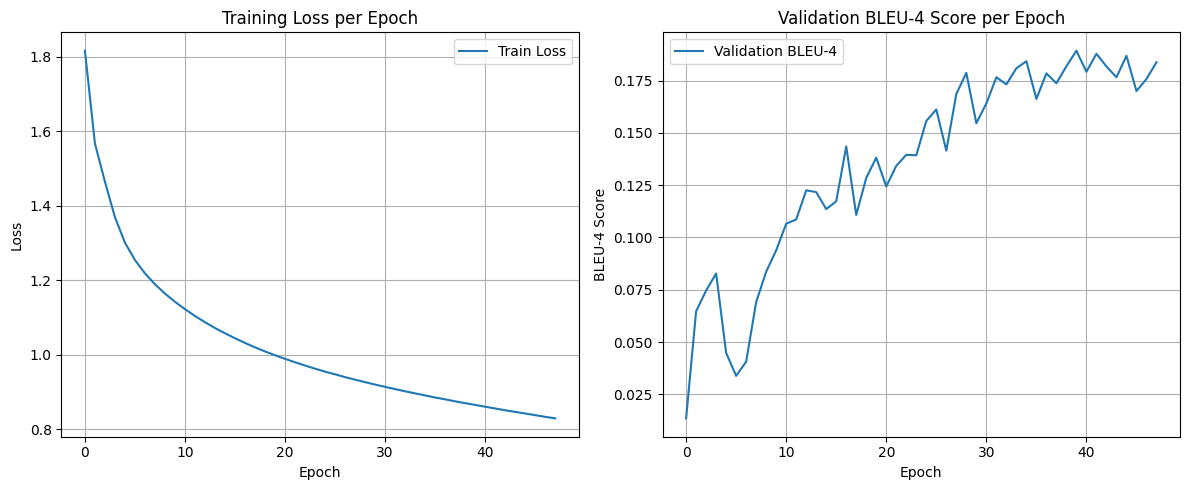

In [23]:
trainer.plot_history()

### MODEL EVALUATION

In [24]:
# Reload the best model
model = ImageCaptioning(CONFIG, processor, feature_extractor_model)

Restored from ./checkpoints/flickr8k_submission/ckpt-17
Training history and states loaded.


In [25]:
model.evaluate_bleu_score(processor.test_data)


Evaluating BLEU on 2025 samples...


100%|██████████| 2025/2025 [02:42<00:00, 12.45it/s]


BLEU-1: 0.5957
BLEU-2: 0.4128
BLEU-3: 0.2738
BLEU-4: 0.1809


{'bleu-1': 0.5956999298901613,
 'bleu-2': 0.4127659332135549,
 'bleu-3': 0.2738166744931043,
 'bleu-4': 0.18094755706109278}

In [29]:
model.evaluate_bleu_score(processor.val_data)


Evaluating BLEU on 4045 samples...


100%|██████████| 4045/4045 [05:17<00:00, 12.74it/s]


BLEU-1: 0.5961
BLEU-2: 0.4116
BLEU-3: 0.2780
BLEU-4: 0.1872


{'bleu-1': 0.5960803059273423,
 'bleu-2': 0.4115639744090149,
 'bleu-3': 0.2779808630443209,
 'bleu-4': 0.18723961591946126}

In [ ]:
model.evaluate_bleu_score(processor.train_data)

In [26]:
model.run_prediction_samples(processor.test_data, num_samples=10)


--- Running Predictions for 10 Random Samples ---

--- Prediction Sample 1/10 (Image: 3561314880_ea9a7e245f.jpg) ---
Ground Truth Captions:
  1. a dirty looking man standing in front of an overfilled red grocery chart
  2. a homeless man has a shopping cart full of junk
  3. a older man is wearing a torn up suit and is leaning on an orange shopping cart full of items
  4. a scruffy man is standing in front of a red shopping cart filled with boxes
  5. a shabby looking man stands near a carriage full of crates
Generated Caption (Beam Search): a man and a woman sitting on a bench
Prediction Time: 494.95 ms

--- Prediction Sample 2/10 (Image: 3453544202_3855ab34b6.jpg) ---
Ground Truth Captions:
  1. a man riding a motorcycle while wearing a black uniform
  2. a motorcyclist rides
  3. a white motorcycle is being ridden around a racetrack
  4. number races his motorcycle while wearing his black and red outfit
  5. person on a red white and black racing motorcycle
Generated Caption (Beam 

### SHOW AND TELL DEMO

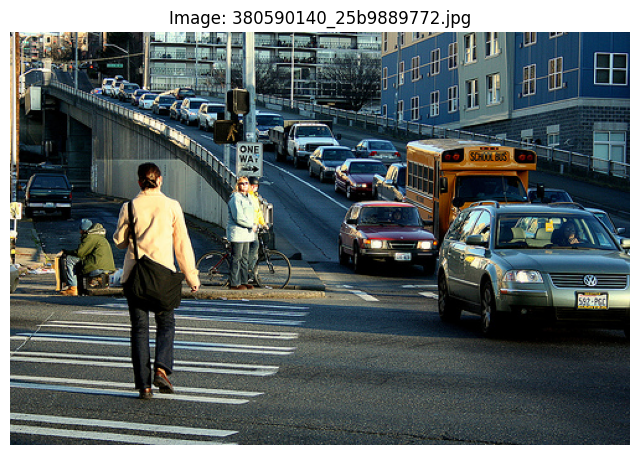


Ground Truth Captions:
  1. a busy highway scene with a woman crossing a crosswalk on the left
  2. a lady crosses a busy road on the crosswalk
  3. a woman crosses a street while traffic lines up in the opposite direction
  4. street with traffic with one person in crosswalk two others at corner and one person sitting on ground
  5. woman walking in crosswalk near a busy street

Generated Caption (Beam Search): a group of people are standing in a city street

Playing generated caption:


Audio saved to caption_audio_380590140_25b9889772.mp3 and played.


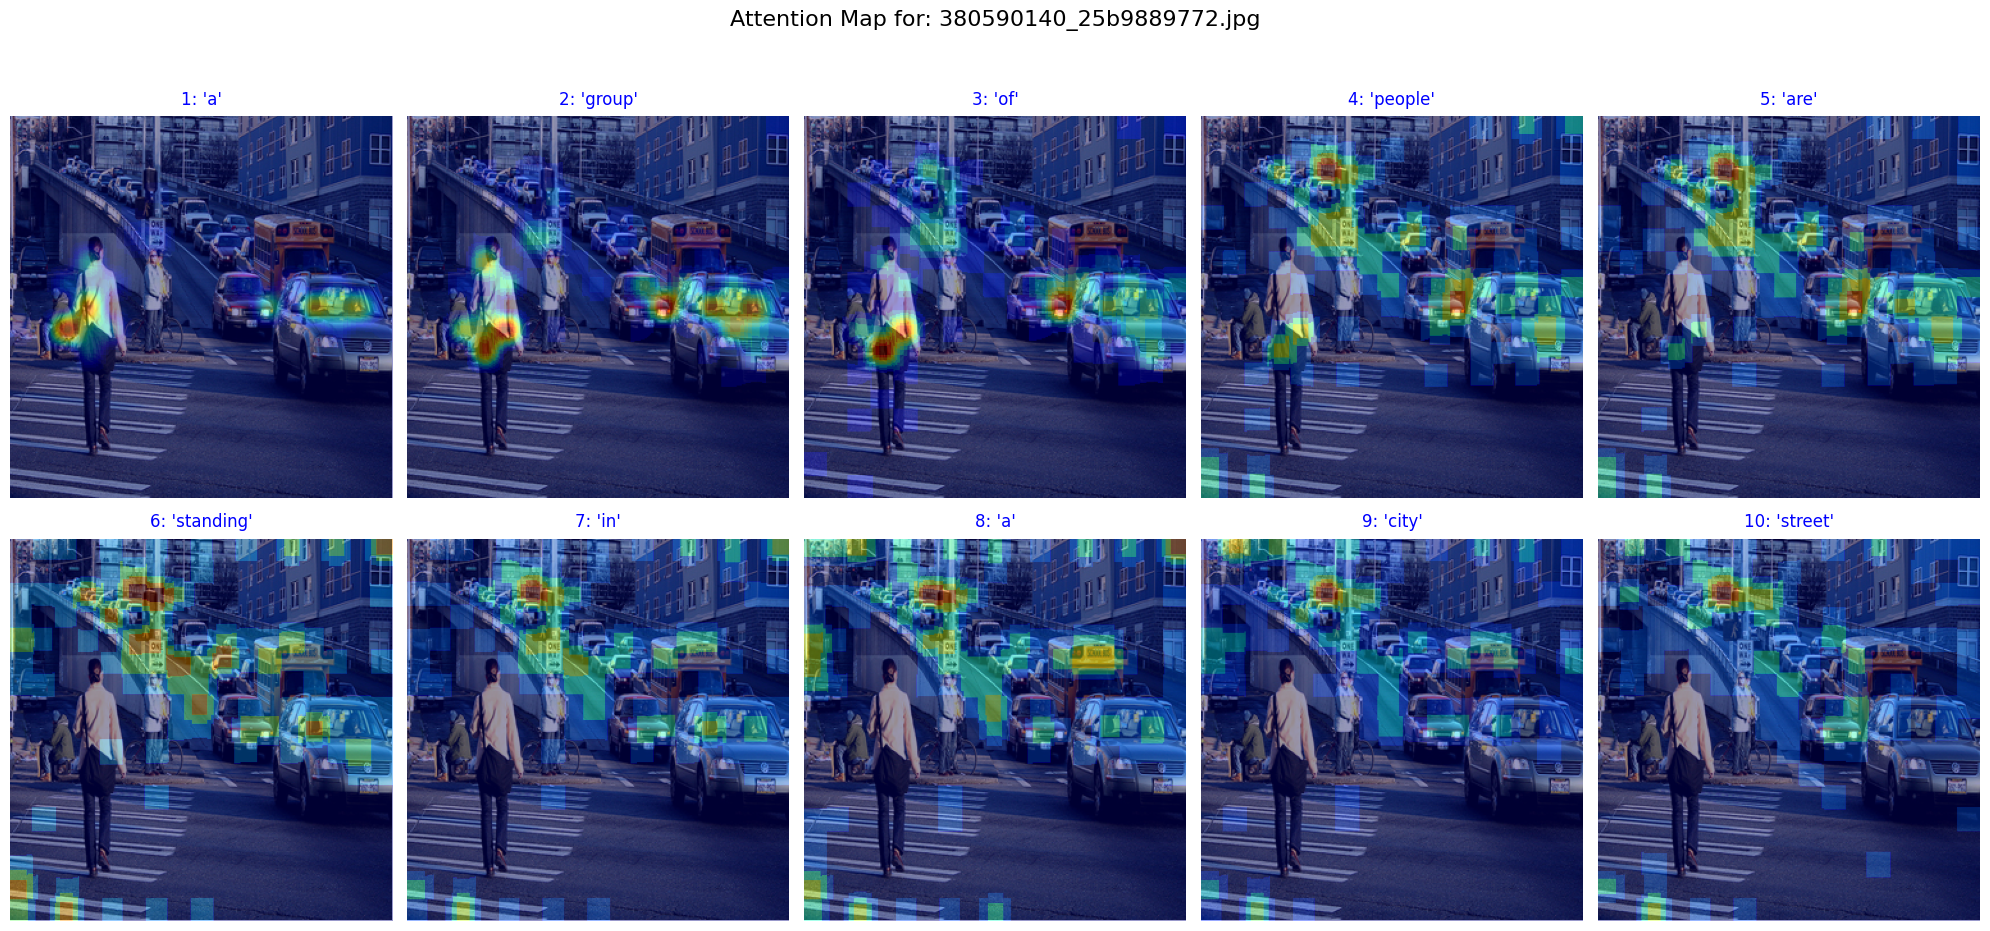

In [27]:
if processor.test_data:
    random_test_img_path, _ = random.choice(processor.test_data)
    model.demo(os.path.basename(random_test_img_path))
else:
    print("No test data available for demo.")

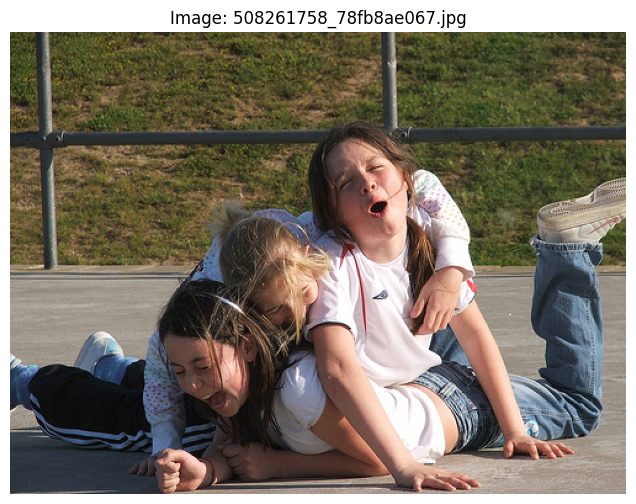


Ground Truth Captions:
  1. three girls fell on top of one another and are laughing histerically
  2. three girls pile on top of each other on the concrete
  3. three girls playing on the ground
  4. three teenage girls rolling all over each other on the ground laughing
  5. three young girls play wrestling and laugh a lot

Generated Caption (Beam Search): a man and a woman sitting on a bench

Playing generated caption:


Audio saved to caption_audio_508261758_78fb8ae067.mp3 and played.


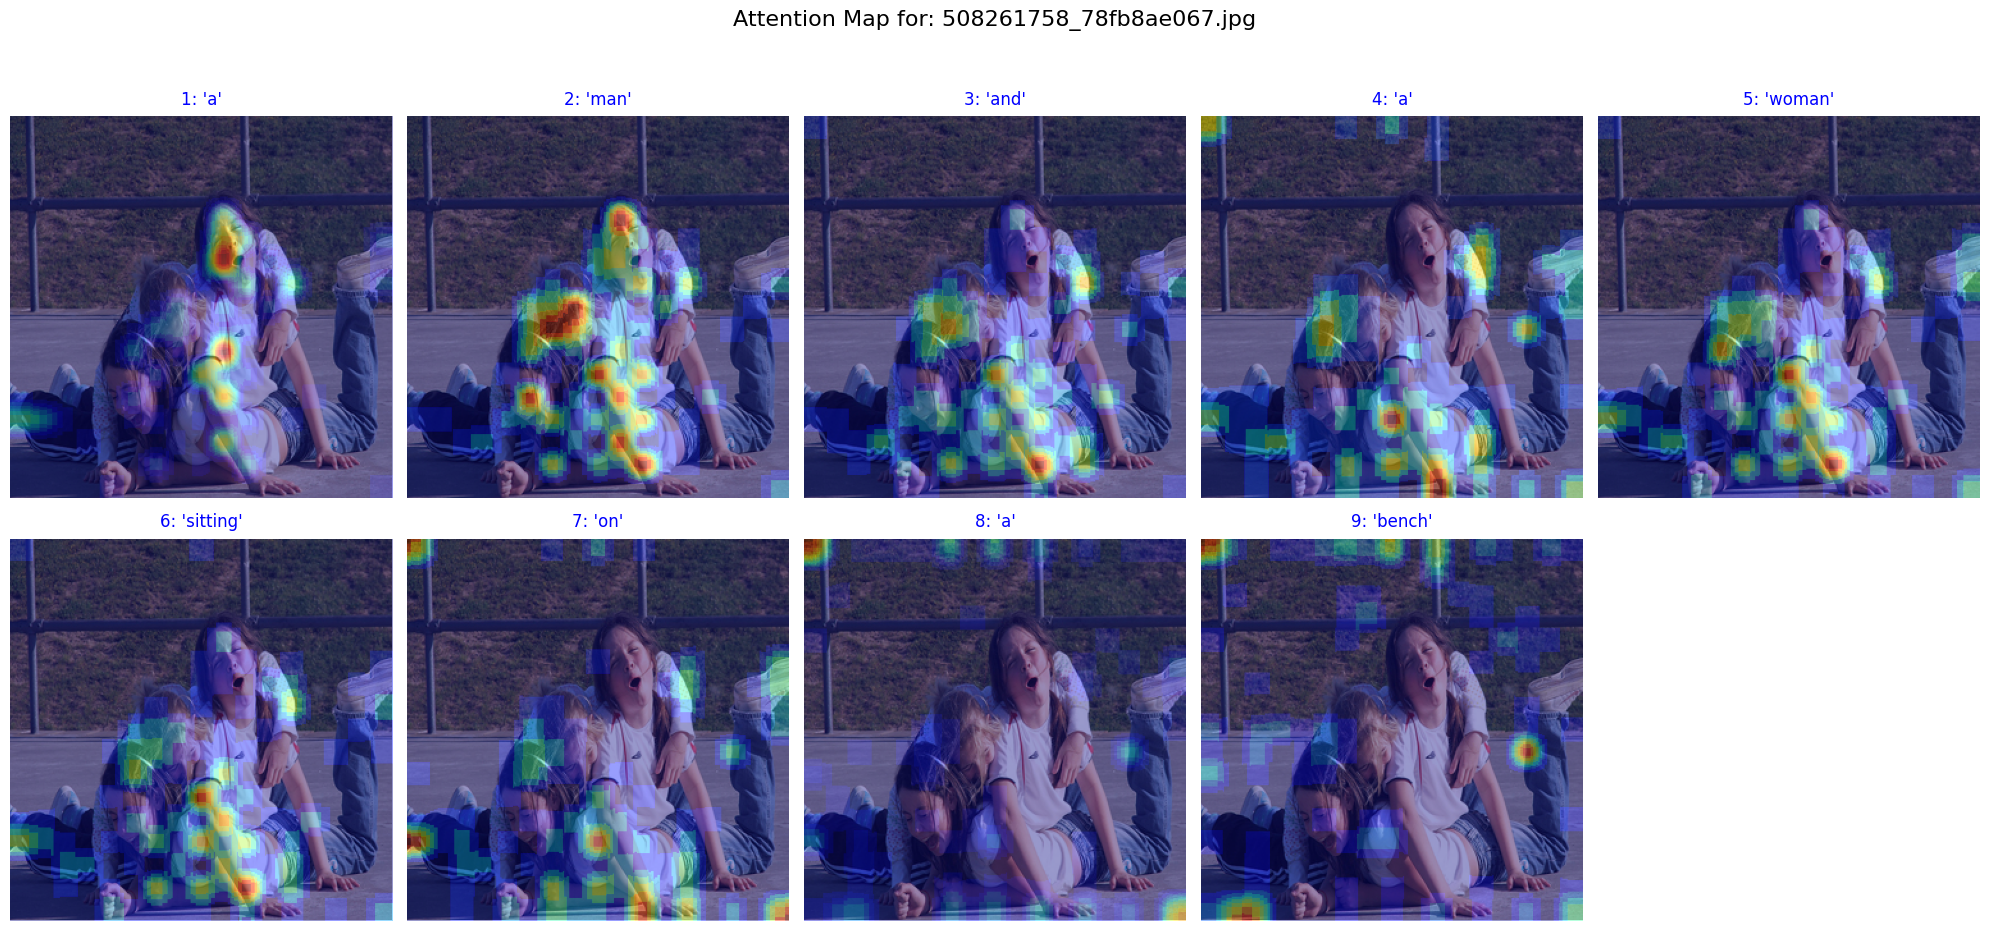

In [30]:
if processor.test_data:
    random_test_img_path, _ = random.choice(processor.test_data)
    model.demo(os.path.basename(random_test_img_path))
else:
    print("No test data available for demo.")

### Comparision with other notable work with Flickr-8k

| Model / Paper (Flickr-8k test split) | BLEU-1 | BLEU-2 | BLEU-3 | BLEU-4 |
|-------------------------------------|:------:|:------:|:------:|:------:|
| **My best checkpoint (Attn)**      | ▢      | ▢      | ▢      | ▢      |
| Xu et al., 2015 — *Soft-Attention*  | 0.67 | 0.448 | 0.299 | 0.195  |
| Xu et al., 2015 — *Hard-Attention*  | 0.67 | 0.457 | 0.314 | 0.213  |
| Google NIC (Vinyals et al., 2015)   | 0.63 | 0.41  | 0.27  | 0.160* |

* BLEU-4 for NIC comes from a later re-implementation that reports full n-gram scores on the official Flickr-8k split.


[^1]: Kelvin Xu, Jimmy Lei Ba, Ryan Kiros, Kyunghyun Cho, Aaron Courville,  
      Ruslan Salakhutdinov, Richard Zemel & Yoshua Bengio.  
      *Show, Attend and Tell: Neural Image Caption Generation with Visual Attention*.  
      Proceedings of the 32nd International Conference on Machine Learning (ICML 2015),  
      PMLR 37, pp. 2048–2057. :contentReference[oaicite:0]{index=0}

[^2]: Oriol Vinyals, Alexander Toshev, Samy Bengio & Dumitru Erhan.  
      *Show and Tell: A Neural Image Caption Generator*.  
      Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR 2015),  
      pp. 3156–3164. DOI 10.1109/CVPR.2015.7298935. :contentReference[oaicite:1]{index=1}
